In [650]:
import pickle
from collections import namedtuple
import pandas as pd
import numpy as np
from importlib import reload
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import datetime

# bench_util module is in the parent directory, because it will be part of
# the production code.  Add the parent directory to the Path so Python can
# import from there
sys.path.insert(0, '../')   
import bench_util as bu
import graph_util as gu

## Unpickle the Dataframe for Preprocessed Utility Data & Make Utility Function Object

In [651]:
# Unpickle the pre-processed DataFrame
df = pickle.load(open('dfu3.pkl', 'rb'))

# Unpickle the raw utility bill DataFrame, which is needed below to make
# the utility function object.
df_raw = pickle.load(open('df_raw.pkl', 'rb'))

df.head()  # the processed data

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2005,12,Electricity charge,kWh,1904.657880,49.5,14790.748577,2006,6,50.466034
1,03,Electricity,2006,1,Electricity charge,kWh,5430.493797,93.0,42665.790911,2006,7,145.575679
2,03,Electricity,2006,2,Electricity charge,kWh,5764.406730,84.0,45010.439348,2006,8,153.575619
3,03,Electricity,2006,3,Electricity charge,kWh,6349.255299,93.0,46311.547557,2006,9,158.015000
4,03,Electricity,2006,4,Electricity charge,kWh,5529.385224,90.0,40392.812893,2006,10,137.820278


In [652]:
# Checking fiscal / calendar year for graph question.
year_2017 = df.query("fiscal_year == 2017")
site_2017 = year_2017.query("site_id == 'DIPMP1'")
year_2017.query("fiscal_mo == 10").head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
171,03,Electricity,2017,4,Electricity charge,kWh,7398.864815,71.5,32458.201369,2017,10,110.747383
469,03,Natural Gas,2017,4,Natural gas (CCF),-,0.000000,30.0,0.000000,2017,10,0.000000
470,03,Natural Gas,2017,4,Other Charge,-,57.469086,30.0,NaN,2017,10,NaN
521,03,Oil #1,2017,4,Fuel Oil #1 (Gallons),-,0.000000,0.5,0.000000,2017,10,0.000000
522,03,Oil #1,2017,4,Fuel Oil #1 (Gallons),Gallons,7133.419194,29.5,3701.806452,2017,10,499.743871


In [653]:
# this is only needed to update any code changes I may have made
# since last importing the module above.
reload(bu) 
reload(gu)

# Make an object that has the various utility functions.
# The object needs access to the raw utility bill DataFrame and the spreadsheet
# containing other application data.
ut = bu.Util(df_raw, '../data/Other_Building_Data.xlsx')

In [654]:
# Testing site.  Final code will loop through all sites
site = 'DIPMP1'

# Energy Use Overview Report - Page 4


In [655]:
# From the main DataFrame, get only the rows for this site, and only get
# the needed columns for this analysis
usage_df1 = df.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo', 'mmbtu']]
usage_df1.head()

,service_type,fiscal_year,fiscal_mo,mmbtu
48636,Electricity,2006,12,85.16352
48637,Electricity,2006,12,0.00000
48638,Electricity,2006,12,NaN
48639,Electricity,2007,1,160.70520
48640,Electricity,2007,1,0.00000


In [656]:
usage_df1.query("service_type == 'Natural Gas'")

,service_type,fiscal_year,fiscal_mo,mmbtu
49133,Natural Gas,2009,2,53.842091
49134,Natural Gas,2009,2,NaN
49135,Natural Gas,2009,3,371.718361
49136,Natural Gas,2009,3,NaN
49137,Natural Gas,2009,4,643.843977
49138,Natural Gas,2009,4,NaN
49139,Natural Gas,2009,5,794.288571
49140,Natural Gas,2009,5,NaN
49141,Natural Gas,2009,6,980.256194
49142,Natural Gas,2009,6,NaN


In [657]:
usage_df2 = pd.pivot_table(
    usage_df1, 
    values='mmbtu', 
    index=['fiscal_year'], 
    columns=['service_type'],
    aggfunc=np.sum
)

usage_df2 = usage_df2.drop(labels=['Sewer', 'Water'], axis=1)

usage_df2

service_type,Electricity,Natural Gas,Oil #1
fiscal_year,,,
2006,85.163520,NaN,56.806579
2007,4062.988275,NaN,725.280637
2008,4475.848805,NaN,736.426534
2009,4683.474489,5199.297000,2112.606964
2010,4984.455578,566.276800,6879.015877
2011,4656.171492,1139.153000,6259.229880
2012,4516.043334,7309.068619,668.293467
2013,4760.229306,7748.241853,798.431211
2014,4665.265022,7340.779372,612.212365


In [658]:
# Add in columns for the missing services
missing_services = bu.missing_energy_services(usage_df2.columns)
bu.add_columns(usage_df2, missing_services)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam
fiscal_year,,,,
2006,85.163520,NaN,56.806579,0.0
2007,4062.988275,NaN,725.280637,0.0
2008,4475.848805,NaN,736.426534,0.0
2009,4683.474489,5199.297000,2112.606964,0.0
2010,4984.455578,566.276800,6879.015877,0.0
2011,4656.171492,1139.153000,6259.229880,0.0
2012,4516.043334,7309.068619,668.293467,0.0
2013,4760.229306,7748.241853,798.431211,0.0
2014,4665.265022,7340.779372,612.212365,0.0


In [659]:
# Add a Total column that sums the other columns
usage_df2['Total_Use'] = usage_df2.sum(axis=1)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use
fiscal_year,,,,,
2006,85.163520,NaN,56.806579,0.0,141.970099
2007,4062.988275,NaN,725.280637,0.0,4788.268912
2008,4475.848805,NaN,736.426534,0.0,5212.275339
2009,4683.474489,5199.297000,2112.606964,0.0,11995.378453
2010,4984.455578,566.276800,6879.015877,0.0,12429.748255
2011,4656.171492,1139.153000,6259.229880,0.0,12054.554371
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760


In [660]:
# Create a list of columns to loop through and calculate percent total energy
usage_cols = list(usage_df2.columns.values)
print (usage_cols)
usage_cols.remove('Total_Use')

for col in usage_cols:
    col_name = col + "_pct_total_energy"
    usage_df2[col_name] = usage_df2[col] / usage_df2.Total_Use

usage_df2

['Electricity', 'Natural Gas', 'Oil #1', 'Steam', 'Total_Use']


service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy
fiscal_year,,,,,,,,,
2006,85.163520,NaN,56.806579,0.0,141.970099,0.599869,NaN,0.400131,0.0
2007,4062.988275,NaN,725.280637,0.0,4788.268912,0.848530,NaN,0.151470,0.0
2008,4475.848805,NaN,736.426534,0.0,5212.275339,0.858713,NaN,0.141287,0.0
2009,4683.474489,5199.297000,2112.606964,0.0,11995.378453,0.390440,0.433442,0.176118,0.0
2010,4984.455578,566.276800,6879.015877,0.0,12429.748255,0.401010,0.045558,0.553432,0.0
2011,4656.171492,1139.153000,6259.229880,0.0,12054.554371,0.386258,0.094500,0.519242,0.0
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0


In [661]:
# Add in degree days
months_present = bu.months_present(usage_df1)
deg_days = ut.degree_days_yearly(months_present, site)
usage_df2['hdd'] = deg_days
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd
fiscal_year,,,,,,,,,,
2006,85.163520,NaN,56.806579,0.0,141.970099,0.599869,NaN,0.400131,0.0,NaN
2007,4062.988275,NaN,725.280637,0.0,4788.268912,0.848530,NaN,0.151470,0.0,NaN
2008,4475.848805,NaN,736.426534,0.0,5212.275339,0.858713,NaN,0.141287,0.0,13802.0
2009,4683.474489,5199.297000,2112.606964,0.0,11995.378453,0.390440,0.433442,0.176118,0.0,12393.0
2010,4984.455578,566.276800,6879.015877,0.0,12429.748255,0.401010,0.045558,0.553432,0.0,12171.0
2011,4656.171492,1139.153000,6259.229880,0.0,12054.554371,0.386258,0.094500,0.519242,0.0,13802.0
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393.0
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171.0
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802.0


In [662]:
# Add in a column to show the numbers of months present for each year
# This will help to identify partial years.
mo_count = bu.month_count(months_present)
usage_df2['month_count'] = mo_count
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count
fiscal_year,,,,,,,,,,,
2006,85.163520,NaN,56.806579,0.0,141.970099,0.599869,NaN,0.400131,0.0,NaN,4
2007,4062.988275,NaN,725.280637,0.0,4788.268912,0.848530,NaN,0.151470,0.0,NaN,12
2008,4475.848805,NaN,736.426534,0.0,5212.275339,0.858713,NaN,0.141287,0.0,13802.0,12
2009,4683.474489,5199.297000,2112.606964,0.0,11995.378453,0.390440,0.433442,0.176118,0.0,12393.0,12
2010,4984.455578,566.276800,6879.015877,0.0,12429.748255,0.401010,0.045558,0.553432,0.0,12171.0,12
2011,4656.171492,1139.153000,6259.229880,0.0,12054.554371,0.386258,0.094500,0.519242,0.0,13802.0,12
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393.0,12
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171.0,12
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802.0,12


In [663]:
# Calculate total heat energy and normalized heating usage
usage_df2['total_heat_energy'] = usage_df2['Natural Gas'] + usage_df2['Steam'] + usage_df2['Oil #1']
usage_df2['total_specific_heat_usage'] = usage_df2['total_heat_energy'] * 1000 / usage_df2.hdd
usage_df2 = usage_df2.query("month_count == 12")
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count,total_heat_energy,total_specific_heat_usage
fiscal_year,,,,,,,,,,,,,
2007,4062.988275,NaN,725.280637,0.0,4788.268912,0.848530,NaN,0.151470,0.0,NaN,12,NaN,NaN
2008,4475.848805,NaN,736.426534,0.0,5212.275339,0.858713,NaN,0.141287,0.0,13802.0,12,NaN,NaN
2009,4683.474489,5199.297000,2112.606964,0.0,11995.378453,0.390440,0.433442,0.176118,0.0,12393.0,12,7311.903964,590.002741
2010,4984.455578,566.276800,6879.015877,0.0,12429.748255,0.401010,0.045558,0.553432,0.0,12171.0,12,7445.292677,611.723990
2011,4656.171492,1139.153000,6259.229880,0.0,12054.554371,0.386258,0.094500,0.519242,0.0,13802.0,12,7398.382880,536.037015
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393.0,12,7977.362086,643.699031
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171.0,12,8546.673064,702.216175
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802.0,12,7952.991738,576.220239
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12393.0,12,6798.165341,548.548805


In [664]:
# Reverse the DataFrame
usage_df2.sort_index(ascending=False, inplace=True)
usage_df2

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count,total_heat_energy,total_specific_heat_usage
fiscal_year,,,,,,,,,,,,,
2017,6832.131566,4379.715484,2137.725000,0.0,13349.572050,0.511787,0.328079,0.160134,0.0,13802.0,12,6517.440484,472.209860
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0,12171.0,12,6761.947500,555.578630
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12393.0,12,6798.165341,548.548805
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802.0,12,7952.991738,576.220239
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171.0,12,8546.673064,702.216175
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393.0,12,7977.362086,643.699031
2011,4656.171492,1139.153000,6259.229880,0.0,12054.554371,0.386258,0.094500,0.519242,0.0,13802.0,12,7398.382880,536.037015
2010,4984.455578,566.276800,6879.015877,0.0,12429.748255,0.401010,0.045558,0.553432,0.0,12171.0,12,7445.292677,611.723990
2009,4683.474489,5199.297000,2112.606964,0.0,11995.378453,0.390440,0.433442,0.176118,0.0,12393.0,12,7311.903964,590.002741


## Create Energy Usage Overview Graphs

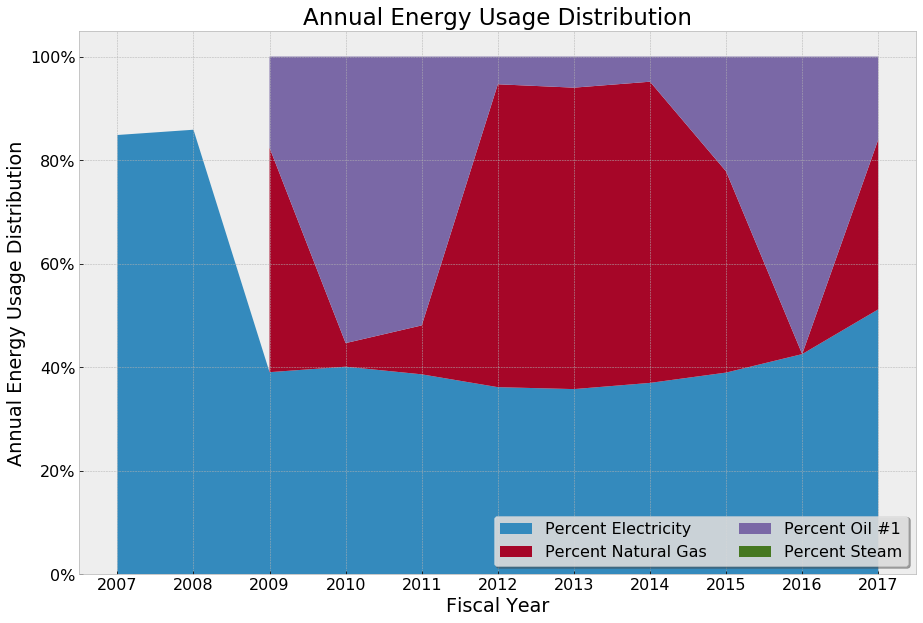

In [665]:
# Reset the index so the fiscal year column can be passed to the graphing function
reset_usage_df2 = usage_df2.reset_index()

# Only graph years with full year usage to prevent confusion
full_year_usage_df2 = reset_usage_df2.query("month_count == 12")


p4g2_filename, p4g2_url = gu.graph_filename_url(site, 'annual_energy_usage_distribution')

# Create the area graph
gu.area_use_distribution(full_year_usage_df2, 'fiscal_year', usage_cols, p4g2_filename)

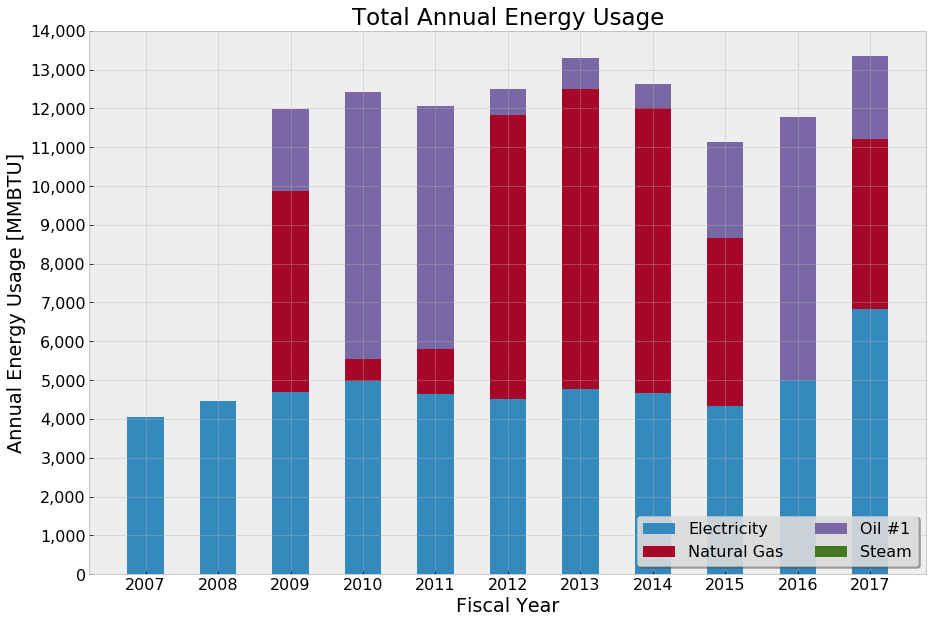

In [666]:
p4g1_filename, p4g1_url = gu.graph_filename_url(site, "annual_energy_usage")

gu.energy_use_stacked_bar(full_year_usage_df2, 'fiscal_year', usage_cols, p4g1_filename)

In [667]:
# Export the rows of the DataFrame into a list of dictionaries for use
# in the template.  Rename columns to match template variables.
usage_dict = bu.df_to_dictionaries(usage_df2, change_names={'Natural Gas': 'natural_gas', 'Oil #1': 'fuel_oil'})
usage_dict

[{'Electricity': 6832.1315664516133,
  'Electricity_pct_total_energy': 0.51178656070001294,
  'Natural Gas_pct_total_energy': 0.32807909252530204,
  'Oil #1_pct_total_energy': 0.16013434677468508,
  'Steam': 0.0,
  'Steam_pct_total_energy': 0.0,
  'Total_Use': 13349.57205032258,
  'fiscal_year': 2017,
  'fuel_oil': 2137.7249999999999,
  'hdd': 13802.0,
  'month_count': 12.0,
  'natural_gas': 4379.7154838709675,
  'total_heat_energy': 6517.440483870967,
  'total_specific_heat_usage': 472.20985972112499},
 {'Electricity': 5005.2842360483864,
  'Electricity_pct_total_energy': 0.42535783677268141,
  'Natural Gas_pct_total_energy': 0.0,
  'Oil #1_pct_total_energy': 0.57464216322731854,
  'Steam': 0.0,
  'Steam_pct_total_energy': 0.0,
  'Total_Use': 11767.231736048387,
  'fiscal_year': 2016,
  'fuel_oil': 6761.9474999999993,
  'hdd': 12171.0,
  'month_count': 12.0,
  'natural_gas': 0.0,
  'total_heat_energy': 6761.9474999999993,
  'total_specific_heat_usage': 555.57862952920868},
 {'Electric

# Create Usage Pie Charts

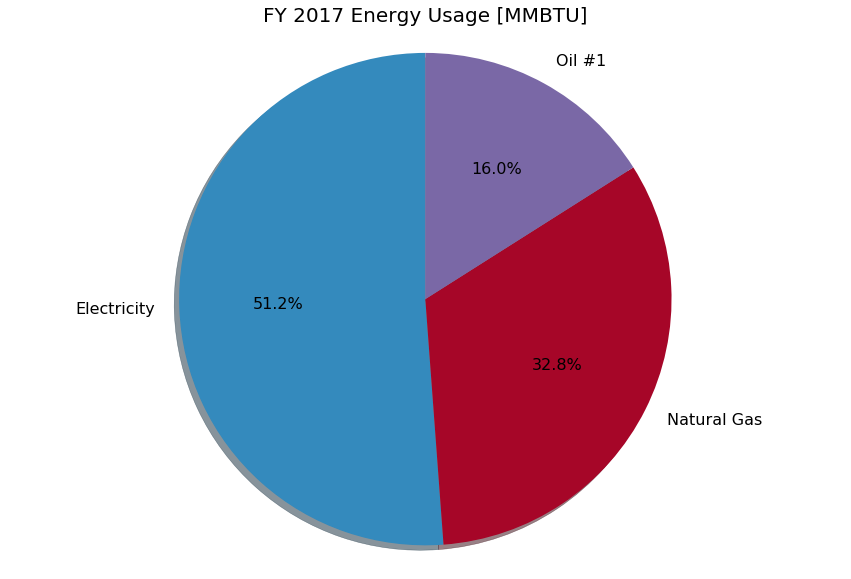

In [668]:
p5g1_filename, p5g1_url = gu.graph_filename_url(site, "energy_usage")
gu.usage_pie_charts(usage_df2, usage_cols, 1, p5g1_filename)

# Electrical Usage Analysis - Page 6

In [669]:
site_df = df.query("site_id == @site")
site_df.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
48636,DIPMP1,Electricity,2006,6,Energy charge,kWh,1971.105,16.5,24960.0,2006,12,85.16352
48637,DIPMP1,Electricity,2006,6,KW Charge,kW,931.745,16.5,117.0,2006,12,0.00000
48638,DIPMP1,Electricity,2006,6,Other Charge,-,621.220,16.5,NaN,2006,12,NaN
48639,DIPMP1,Electricity,2006,7,Energy charge,kWh,3736.435,31.0,47100.0,2007,1,160.70520
48640,DIPMP1,Electricity,2006,7,KW Charge,kW,1863.490,31.0,234.0,2007,1,0.00000


In [670]:
# only look at elecricity records
electric_df = site_df.query("service_type == 'Electricity'")

In [671]:
# Make sure I'm not potentially missing anything with funky unit names
check_df = electric_df.query("usage > 0")
check_df.units.unique()

array(['kWh', 'kW', 'kVAR'], dtype=object)

In [672]:
electric_df = electric_df.query("units == 'kWh' or units == 'kW'")
electric_df.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
48636,DIPMP1,Electricity,2006,6,Energy charge,kWh,1971.105000,16.5,24960.000000,2006,12,85.163520
48637,DIPMP1,Electricity,2006,6,KW Charge,kW,931.745000,16.5,117.000000,2006,12,0.000000
48639,DIPMP1,Electricity,2006,7,Energy charge,kWh,3736.435000,31.0,47100.000000,2007,1,160.705200
48640,DIPMP1,Electricity,2006,7,KW Charge,kW,1863.490000,31.0,234.000000,2007,1,0.000000
48642,DIPMP1,Electricity,2006,8,Energy charge,kWh,3476.768548,31.0,43409.032258,2007,2,148.111618


In [673]:
electric_df.query("units == 'kWh'")['item_desc'].unique()

array(['Energy charge', 'Utility Charge'], dtype=object)

In [674]:
electric_df.item_desc.unique()

array(['Energy charge', 'KW Charge', 'On peak demand', 'Demand Charge',
       'Utility Charge', 'Actual demand'], dtype=object)

In [675]:
electric_pivot_monthly = pd.pivot_table(electric_df,
                                        index=['fiscal_year', 'fiscal_mo'], 
                                        columns=['units'],
                                        values='usage',
                                        aggfunc=np.sum)

electric_pivot_monthly.head()

units                          kW            kWh
fiscal_year fiscal_mo                           
2006        12         117.000000   24960.000000
2007        1          234.000000   47100.000000
            2          241.548387   43409.032258
            3          287.701613   54695.253456
            4          320.078125  107151.964286

In [676]:
# Do a month count for the elecricity bills 
elec_months_present = bu.months_present(electric_pivot_monthly.reset_index())
elec_mo_count = bu.month_count(elec_months_present)
elec_mo_count_df = pd.DataFrame(elec_mo_count)
elec_mo_count_df

,month
year,
2006,1
2007,12
2008,12
2009,12
2010,12
2011,12
2012,12
2013,12
2014,12


In [677]:
electric_pivot_annual = pd.pivot_table(electric_df,
                                       index=['fiscal_year'],
                                       columns=['units'],
                                       values='usage',
                                       aggfunc=np.sum
                                      )
                                       
electric_use_annual = electric_pivot_annual[['kWh']]
electric_use_annual = electric_use_annual.rename(columns={'kWh':'ann_electric_usage_kWh'})
electric_use_annual

units,ann_electric_usage_kWh
fiscal_year,
2006,2.496000e+04
2007,1.190794e+06
2008,1.311796e+06
2009,1.372648e+06
2010,1.460860e+06
2011,1.364646e+06
2012,1.323577e+06
2013,1.395143e+06
2014,1.367311e+06


In [678]:
# Get average annual demand usage
electric_demand_avg = electric_pivot_monthly.groupby(['fiscal_year']).mean()
electric_demand_avg = electric_demand_avg[['kW']]
electric_demand_avg = electric_demand_avg.rename(columns={'kW': 'avg_demand_kW'})
electric_demand_avg

units,avg_demand_kW
fiscal_year,
2006,117.000000
2007,270.565104
2008,247.520313
2009,261.967202
2010,292.492273
2011,301.101613
2012,265.742687
2013,278.553146
2014,249.558703


In [679]:
# Find annual maximum demand usage
electric_demand_max = electric_pivot_monthly.groupby(['fiscal_year']).max()
electric_demand_max = electric_demand_max[['kW']]
electric_demand_max = electric_demand_max.rename(columns={'kW': 'max_demand_kW'})
electric_demand_max

units,max_demand_kW
fiscal_year,
2006,117.000000
2007,320.078125
2008,321.336000
2009,281.265517
2010,330.574138
2011,430.021119
2012,287.280311
2013,303.987857
2014,294.672414


In [680]:
# Combine dataframes
electric_demand_join = pd.merge(electric_demand_max, electric_demand_avg, how='outer', left_index=True, right_index=True)
annual_electric_data = pd.merge(electric_demand_join, electric_use_annual, how='outer', left_index=True, right_index=True)
annual_electric_data

units,max_demand_kW,avg_demand_kW,ann_electric_usage_kWh
fiscal_year,,,
2006,117.000000,117.000000,2.496000e+04
2007,320.078125,270.565104,1.190794e+06
2008,321.336000,247.520313,1.311796e+06
2009,281.265517,261.967202,1.372648e+06
2010,330.574138,292.492273,1.460860e+06
2011,430.021119,301.101613,1.364646e+06
2012,287.280311,265.742687,1.323577e+06
2013,303.987857,278.553146,1.395143e+06
2014,294.672414,249.558703,1.367311e+06


In [681]:
# Add percent change columns
annual_electric_data['usage_pct_change'] = annual_electric_data.ann_electric_usage_kWh.pct_change()
annual_electric_data['avg_demand_pct_change'] = annual_electric_data.avg_demand_kW.pct_change()
annual_electric_data['max_demand_pct_change'] = annual_electric_data.max_demand_kW.pct_change()
annual_electric_data = annual_electric_data.rename(columns={'avg_demand_kW': 'Average kW',
                                                           'ann_electric_usage_kWh': 'Total kWh'})
annual_electric_data = pd.merge(annual_electric_data, elec_mo_count_df, left_index=True, right_index=True, how='left')
annual_electric_data = annual_electric_data.query("month == 12")
annual_electric_data = annual_electric_data.sort_index(ascending=False)
annual_electric_data

,max_demand_kW,Average kW,Total kWh,usage_pct_change,avg_demand_pct_change,max_demand_pct_change,month
fiscal_year,,,,,,,
2017,569.872970,390.847177,2.002383e+06,0.364984,0.417757,0.936318,12
2016,294.307489,275.680036,1.466965e+06,0.153354,0.072229,0.023439,12
2015,287.567186,257.109245,1.271912e+06,-0.069771,0.030256,-0.024112,12
2014,294.672414,249.558703,1.367311e+06,-0.019950,-0.104089,-0.030644,12
2013,303.987857,278.553146,1.395143e+06,0.054071,0.048206,0.058158,12
2012,287.280311,265.742687,1.323577e+06,-0.030095,-0.117432,-0.331939,12
2011,430.021119,301.101613,1.364646e+06,-0.065862,0.029434,0.300831,12
2010,330.574138,292.492273,1.460860e+06,0.064264,0.116522,0.175310,12
2009,281.265517,261.967202,1.372648e+06,0.046388,0.058366,-0.124700,12


## Create Electrical Usage Analysis Graphs - Page 6

In [682]:
# Axes labels
ylabel1 = 'Electricity Usage [kWh]'
ylabel2 = 'Electricity Demand [kW]'

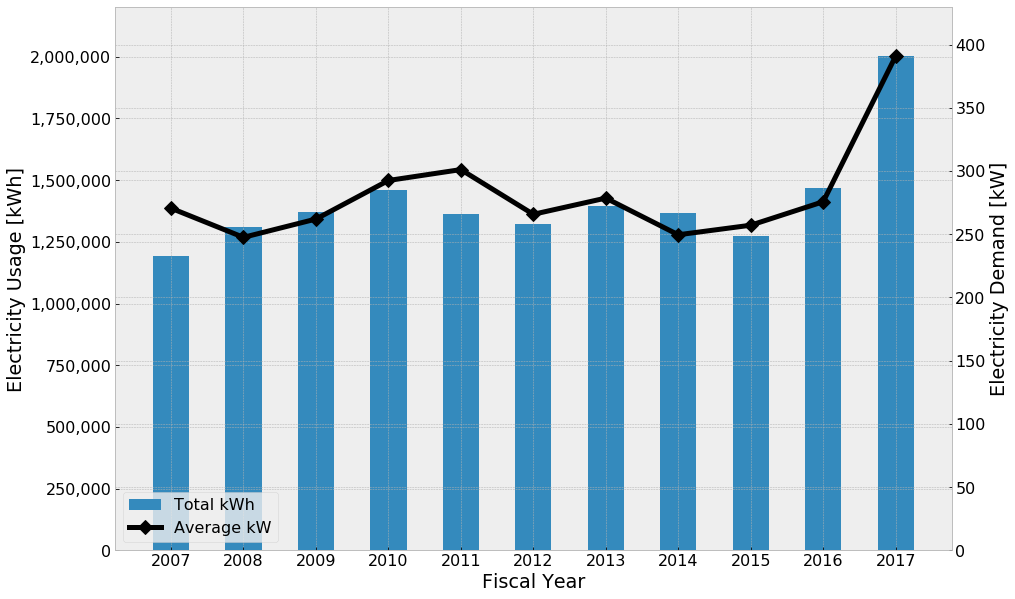

In [683]:
p6g1_filename, p6g1_url = gu.graph_filename_url(site, "electricity_usage")
gu.stacked_bar_with_line(annual_electric_data.reset_index(), 'fiscal_year', ['Total kWh'], 'Average kW', 
                      ylabel1, ylabel2, p6g1_filename)

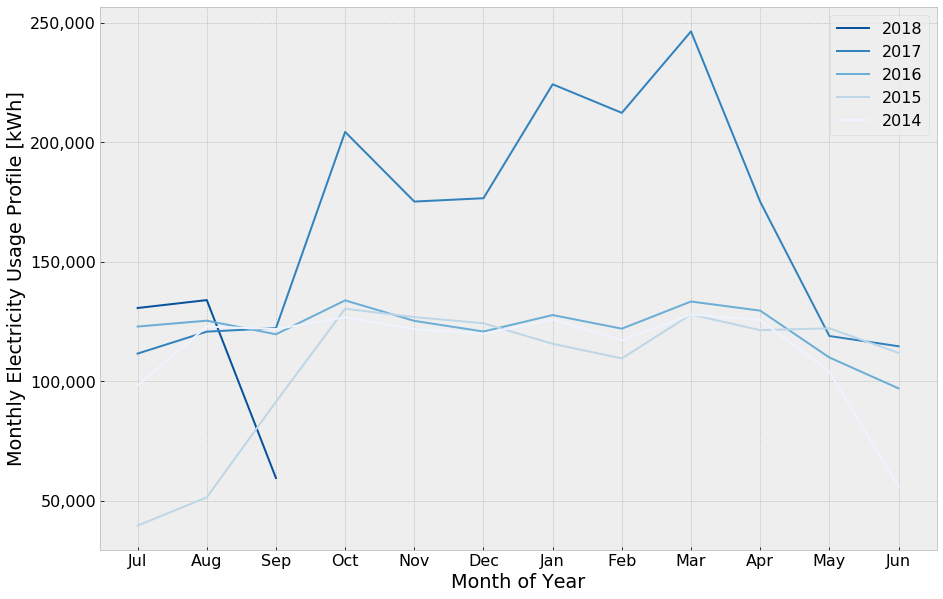

In [684]:
p6g2_filename, p6g2_url = gu.graph_filename_url(site, "monthly_electricity_usage_profile")
gu.create_monthly_profile(electric_pivot_monthly, 'kWh', 'Monthly Electricity Usage Profile [kWh]', 'blue',
                         p6g2_filename)

## Electrical Cost Analysis Table - Page 7

In [685]:
# only look at elecricity records
electric_cost_df = site_df.query("service_type == 'Electricity'")

In [686]:
electric_cost_df.item_desc.unique()

array(['Energy charge', 'KW Charge', 'Other Charge', 'On peak demand',
       'Demand Charge', 'Utility Charge', 'kVAR', 'Actual demand'], dtype=object)

In [687]:
# Costs don't always have units, so split the data into demand charges and usage charges (which includes other charges)
electric_cost_df['cost_categories'] = np.where(electric_cost_df.item_desc.isin(['KW Charge', 'On peak demand', 'Demand Charge']),
                                               'demand_cost', 'usage_cost')

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [688]:
# Sum costs by demand and usage
electric_annual_cost = pd.pivot_table(electric_cost_df,
                                       index=['fiscal_year'],
                                       columns=['cost_categories'],
                                       values='cost',
                                       aggfunc=np.sum
                                      )
# Create a total column
electric_annual_cost['Total Cost'] = electric_annual_cost.demand_cost + electric_annual_cost.usage_cost

electric_annual_cost

cost_categories,demand_cost,usage_cost,Total Cost
fiscal_year,,,
2006,931.745000,2592.325000,3524.070000
2007,26008.199375,124952.422656,150960.622031
2008,27417.794062,185717.228125,213135.022187
2009,27322.788420,173232.085076,200554.873496
2010,30406.295240,202389.183336,232795.478576
2011,32772.982097,195928.582097,228701.564194
2012,34696.867525,225266.682772,259963.550297
2013,38146.446023,236993.286421,275139.732445
2014,39515.007883,211917.016079,251432.023962


In [689]:
# Add percent change columns
electric_annual_cost['usage_cost_pct_change'] = electric_annual_cost.usage_cost.pct_change()
electric_annual_cost['demand_cost_pct_change'] = electric_annual_cost.demand_cost.pct_change()
electric_annual_cost['total_cost_pct_change'] = electric_annual_cost['Total Cost'].pct_change()
electric_annual_cost

cost_categories,demand_cost,usage_cost,Total Cost,usage_cost_pct_change,demand_cost_pct_change,total_cost_pct_change
fiscal_year,,,,,,
2006,931.745000,2592.325000,3524.070000,NaN,NaN,NaN
2007,26008.199375,124952.422656,150960.622031,47.200909,26.913431,41.837010
2008,27417.794062,185717.228125,213135.022187,0.486304,0.054198,0.411858
2009,27322.788420,173232.085076,200554.873496,-0.067227,-0.003465,-0.059024
2010,30406.295240,202389.183336,232795.478576,0.168312,0.112855,0.160757
2011,32772.982097,195928.582097,228701.564194,-0.031922,0.077835,-0.017586
2012,34696.867525,225266.682772,259963.550297,0.149739,0.058703,0.136693
2013,38146.446023,236993.286421,275139.732445,0.052057,0.099420,0.058378
2014,39515.007883,211917.016079,251432.023962,-0.105810,0.035877,-0.086166


In [690]:
electric_use_and_cost = pd.merge(electric_annual_cost, annual_electric_data, left_index=True, right_index=True, how='outer')
electric_use_and_cost = electric_use_and_cost.query("month == 12")
electric_use_and_cost = electric_use_and_cost.sort_index(ascending=False)
electric_use_and_cost

,demand_cost,usage_cost,Total Cost,usage_cost_pct_change,demand_cost_pct_change,total_cost_pct_change,max_demand_kW,Average kW,Total kWh,usage_pct_change,avg_demand_pct_change,max_demand_pct_change,month
fiscal_year,,,,,,,,,,,,,
2017,47738.260484,358553.796129,406292.056613,0.797092,0.047793,0.657796,569.872970,390.847177,2.002383e+06,0.364984,0.417757,0.936318,12.0
2016,45560.764985,199518.886683,245079.651668,0.066822,0.135625,0.078975,294.307489,275.680036,1.466965e+06,0.153354,0.072229,0.023439,12.0
2015,40119.548906,187021.650625,227141.199531,-0.117477,0.015299,-0.096610,287.567186,257.109245,1.271912e+06,-0.069771,0.030256,-0.024112,12.0
2014,39515.007883,211917.016079,251432.023962,-0.105810,0.035877,-0.086166,294.672414,249.558703,1.367311e+06,-0.019950,-0.104089,-0.030644,12.0
2013,38146.446023,236993.286421,275139.732445,0.052057,0.099420,0.058378,303.987857,278.553146,1.395143e+06,0.054071,0.048206,0.058158,12.0
2012,34696.867525,225266.682772,259963.550297,0.149739,0.058703,0.136693,287.280311,265.742687,1.323577e+06,-0.030095,-0.117432,-0.331939,12.0
2011,32772.982097,195928.582097,228701.564194,-0.031922,0.077835,-0.017586,430.021119,301.101613,1.364646e+06,-0.065862,0.029434,0.300831,12.0
2010,30406.295240,202389.183336,232795.478576,0.168312,0.112855,0.160757,330.574138,292.492273,1.460860e+06,0.064264,0.116522,0.175310,12.0
2009,27322.788420,173232.085076,200554.873496,-0.067227,-0.003465,-0.059024,281.265517,261.967202,1.372648e+06,0.046388,0.058366,-0.124700,12.0


## Create Electrical Cost Analysis Graphs - Page 7

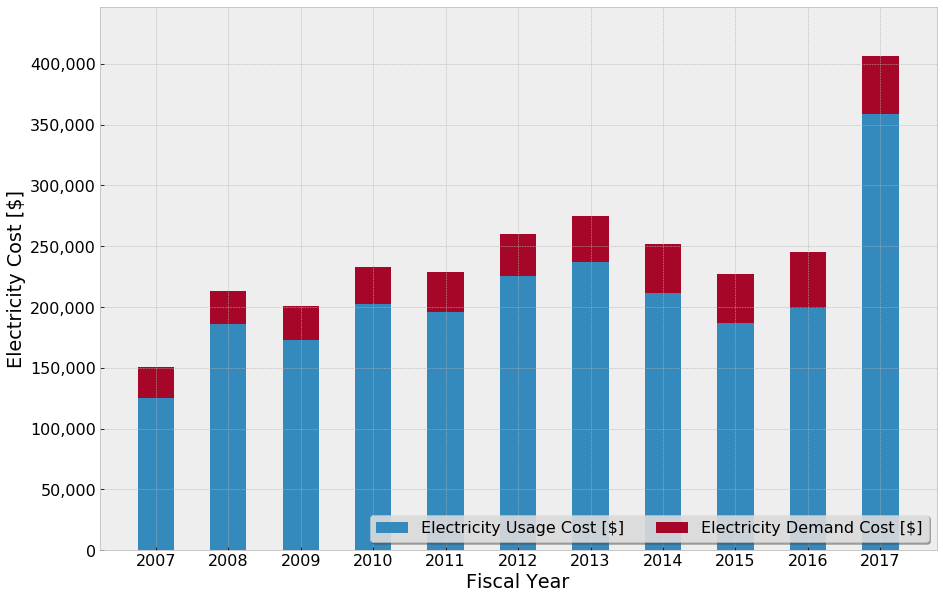

In [691]:
p7g1_filename, p7g1_url = gu.graph_filename_url(site, "electricity_cost")

renamed_use_and_cost = electric_use_and_cost.rename(columns={'usage_cost':'Electricity Usage Cost [$]',
                                                            'demand_cost':'Electricity Demand Cost [$]'})
gu.create_stacked_bar(renamed_use_and_cost.reset_index(), 'fiscal_year', ['Electricity Usage Cost [$]', 
                                                                          'Electricity Demand Cost [$]'], 
                      'Electricity Cost [$]', p7g1_filename)

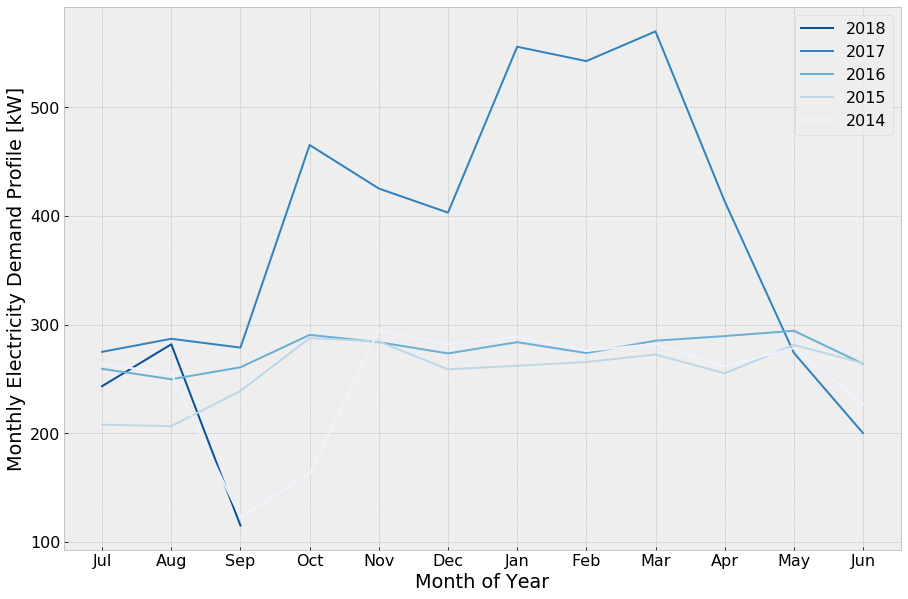

In [692]:
# Create Monthly Profile of Electricity Demand
p7g2_filename, p7g2_url = gu.graph_filename_url(site, "monthly_electricity_demand_profile")
gu.create_monthly_profile(electric_pivot_monthly, 'kW', 'Monthly Electricity Demand Profile [kW]', 'blue', 
                          p7g2_filename)

# Create Heating Usage Analysis Table - Page 8

In [693]:
# Take only needed columns from earlier usage df
heating_usage = usage_df2[['Natural Gas', 'Oil #1', 'Steam', 'hdd', 'month_count', 'total_heat_energy']]
heating_usage

service_type,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy
fiscal_year,,,,,,
2017,4379.715484,2137.725000,0.0,13802.0,12,6517.440484
2016,0.000000,6761.947500,0.0,12171.0,12,6761.947500
2015,4328.011355,2470.153986,0.0,12393.0,12,6798.165341
2014,7340.779372,612.212365,0.0,13802.0,12,7952.991738
2013,7748.241853,798.431211,0.0,12171.0,12,8546.673064
2012,7309.068619,668.293467,0.0,12393.0,12,7977.362086
2011,1139.153000,6259.229880,0.0,13802.0,12,7398.382880
2010,566.276800,6879.015877,0.0,12171.0,12,7445.292677
2009,5199.297000,2112.606964,0.0,12393.0,12,7311.903964


In [694]:
# Add in percent change columns
heating_usage['Oil #1_pct_change'] = heating_usage['Oil #1'].pct_change()
heating_usage['Natural Gas_pct_change'] = heating_usage['Natural Gas'].pct_change()
heating_usage['Steam_pct_change'] = heating_usage['Steam'].pct_change()
heating_usage['total_heat_energy_pct_change'] = heating_usage.total_heat_energy.pct_change()
heating_usage

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

service_type,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy,Oil #1_pct_change,Natural Gas_pct_change,Steam_pct_change,total_heat_energy_pct_change
fiscal_year,,,,,,,,,,
2017,4379.715484,2137.725000,0.0,13802.0,12,6517.440484,NaN,NaN,NaN,NaN
2016,0.000000,6761.947500,0.0,12171.0,12,6761.947500,2.163151,-1.000000,NaN,0.037516
2015,4328.011355,2470.153986,0.0,12393.0,12,6798.165341,-0.634698,inf,NaN,0.005356
2014,7340.779372,612.212365,0.0,13802.0,12,7952.991738,-0.752156,0.696109,NaN,0.169873
2013,7748.241853,798.431211,0.0,12171.0,12,8546.673064,0.304174,0.055507,NaN,0.074649
2012,7309.068619,668.293467,0.0,12393.0,12,7977.362086,-0.162992,-0.056680,NaN,-0.066612
2011,1139.153000,6259.229880,0.0,13802.0,12,7398.382880,8.365990,-0.844145,NaN,-0.072578
2010,566.276800,6879.015877,0.0,12171.0,12,7445.292677,0.099020,-0.502897,NaN,0.006341
2009,5199.297000,2112.606964,0.0,12393.0,12,7311.903964,-0.692891,8.181547,NaN,-0.017916


In [695]:
# Get the number of gallons, ccf, and 1,000 pounds of district heat by converting MMBTUs using the supplied conversions
heating_usage['Oil #1 Gallons'] = heating_usage['Oil #1'] * 1000000 / ut.fuel_btus_per_unit('Oil #1', 'gallons')
heating_usage['Natural Gas ccf'] = heating_usage['Natural Gas'] * 1000000 / ut.fuel_btus_per_unit('Natural Gas', 'ccf')
full_year_heating_usage = heating_usage.query("month_count == 12")
full_year_heating_usage

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


service_type,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy,Oil #1_pct_change,Natural Gas_pct_change,Steam_pct_change,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf
fiscal_year,,,,,,,,,,,,
2017,4379.715484,2137.725000,0.0,13802.0,12,6517.440484,NaN,NaN,NaN,NaN,15835.000000,42938.387097
2016,0.000000,6761.947500,0.0,12171.0,12,6761.947500,2.163151,-1.000000,NaN,0.037516,50088.500000,0.000000
2015,4328.011355,2470.153986,0.0,12393.0,12,6798.165341,-0.634698,inf,NaN,0.005356,18297.436937,42431.483871
2014,7340.779372,612.212365,0.0,13802.0,12,7952.991738,-0.752156,0.696109,NaN,0.169873,4534.906411,71968.425220
2013,7748.241853,798.431211,0.0,12171.0,12,8546.673064,0.304174,0.055507,NaN,0.074649,5914.305263,75963.155425
2012,7309.068619,668.293467,0.0,12393.0,12,7977.362086,-0.162992,-0.056680,NaN,-0.066612,4950.321977,71657.535484
2011,1139.153000,6259.229880,0.0,13802.0,12,7398.382880,8.365990,-0.844145,NaN,-0.072578,46364.665775,11168.166667
2010,566.276800,6879.015877,0.0,12171.0,12,7445.292677,0.099020,-0.502897,NaN,0.006341,50955.673160,5551.733333
2009,5199.297000,2112.606964,0.0,12393.0,12,7311.903964,-0.692891,8.181547,NaN,-0.017916,15648.940476,50973.500000


## Create Heating Usage Analysis Graphs - Page 8

C:\Anaconda2\envs\py35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


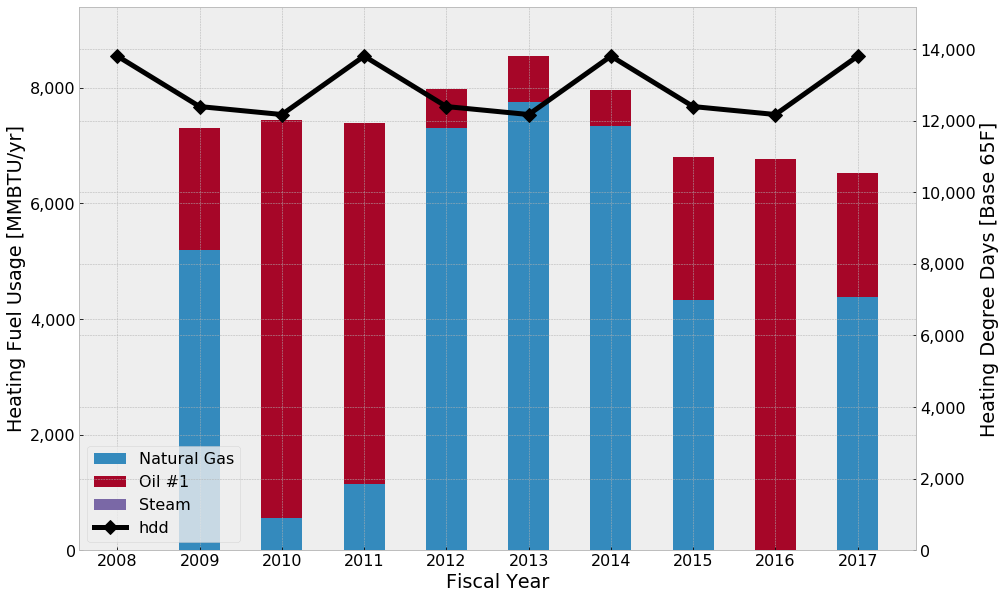

In [696]:
p8g1_filename, p8g1_url = gu.graph_filename_url(site, "heating_degree_days")
gu.stacked_bar_with_line(full_year_heating_usage.reset_index(), 'fiscal_year', ['Natural Gas', 'Oil #1', 'Steam'], 'hdd',
                        'Heating Fuel Usage [MMBTU/yr]', 'Heating Degree Days [Base 65F]', p8g1_filename)

### Create Monthly Heating Usage dataframe for graph

In [697]:
monthly_heating = pd.pivot_table(usage_df1,
                                values='mmbtu',
                                index=['fiscal_year', 'fiscal_mo'],
                                columns=['service_type'],
                                aggfunc=np.sum
                                )
monthly_heating.head()

service_type           Electricity  Natural Gas     Oil #1  Sewer  Water
fiscal_year fiscal_mo                                                   
2006        9                  NaN          NaN   6.373421    NaN    NaN
            10                 NaN          NaN  16.626316    NaN    NaN
            11                 NaN          NaN  17.180526    NaN    NaN
            12            85.16352          NaN  16.626316    NaN    NaN
2007        1            160.70520          NaN  17.180526    NaN    NaN

In [698]:
# Add in columns for the missing energy services
missing_services = bu.missing_energy_services(monthly_heating.columns)
bu.add_columns(monthly_heating, missing_services)

# Drop the non-heating services
monthly_heating = monthly_heating.drop(labels=['Electricity', 'Sewer', 'Water'], axis=1)

# Create a total heating column
monthly_heating['total_heating_energy'] = monthly_heating.sum(axis=1)

monthly_heating.head()

service_type           Natural Gas     Oil #1  Steam  total_heating_energy
fiscal_year fiscal_mo                                                     
2006        9                  NaN   6.373421    0.0              6.373421
            10                 NaN  16.626316    0.0             16.626316
            11                 NaN  17.180526    0.0             17.180526
            12                 NaN  16.626316    0.0             16.626316
2007        1                  NaN  17.180526    0.0             17.180526

In [699]:
# Only send records for full years to graphing function
#reset_monthly_heating = pd.merge(reset_monthly_heating, mo_count_df, left_on='fiscal_year', right_index=True, how='left')
#full_year_monthly_heating = reset_monthly_heating.query("month == 12")
#full_year_monthly_heating = full_year_monthly_heating.set_index(['fiscal_year', 'fiscal_mo'])
#full_year_monthly_heating

In [700]:
# Identify partial years through the use of the month_count utility
#reset_monthly_heating = monthly_heating.reset_index()
#months_present = bu.months_present(reset_monthly_heating)#mo_count = bu.month_count(months_present)
#mo_count_df = pd.DataFrame(mo_count)
#mo_count_df

C:\Anaconda2\envs\py35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


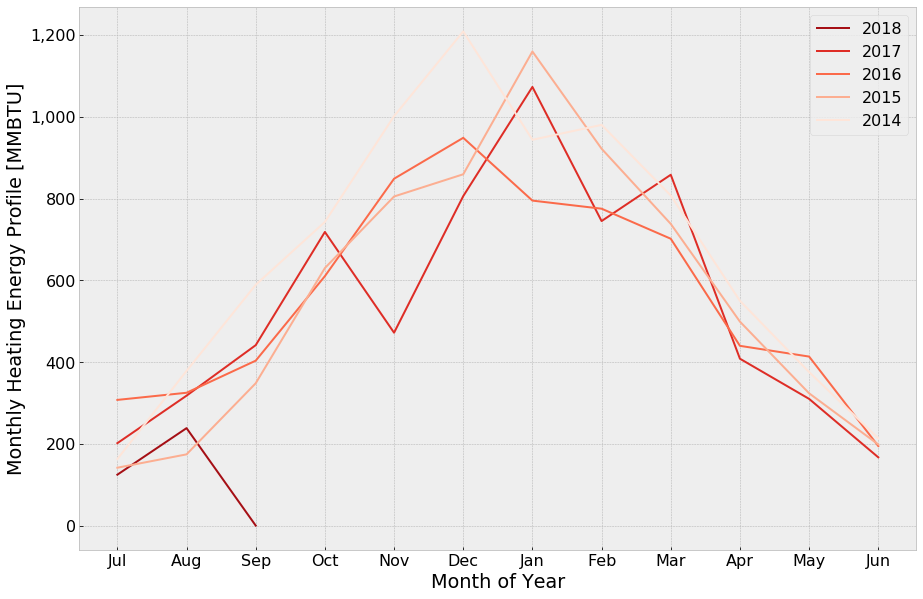

In [701]:
p8g2_filename, p8g2_url = gu.graph_filename_url(site, "monthly_heating_energy_profile")
gu.create_monthly_profile(monthly_heating, 'total_heating_energy', "Monthly Heating Energy Profile [MMBTU]", 'red',
                          p8g2_filename)

## Heating Cost Analysis Table - Page 9

In [702]:
# Import df that I exported from "alan_report_pages".  This can be removed once code is combined
df2 = pd.read_csv(r"C:\Users\dustin\Google Drive\FNSB Data Analysis\data_from_alan_report_pages_df2.csv")

# Use only necessary columns
heating_cost = df2[['fiscal_year', 'Natural Gas', 'Oil #1', 'Steam', 'Total', 'pct_change']]

# Change column names so they aren't the same as the heating usage dataframe
heating_cost = heating_cost.rename(columns={'Natural Gas':'Natural Gas Cost',
                                           'Oil #1': 'Oil #1 Cost',
                                           'Steam': 'Steam Cost',
                                           'Total': 'Total Heat Cost',
                                           'pct_change': 'Total Cost % Change'})
heating_cost

,fiscal_year,Natural Gas Cost,Oil #1 Cost,Steam Cost,Total Heat Cost,Total Cost % Change
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN


In [703]:
heating_usage

service_type,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy,Oil #1_pct_change,Natural Gas_pct_change,Steam_pct_change,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf
fiscal_year,,,,,,,,,,,,
2017,4379.715484,2137.725000,0.0,13802.0,12,6517.440484,NaN,NaN,NaN,NaN,15835.000000,42938.387097
2016,0.000000,6761.947500,0.0,12171.0,12,6761.947500,2.163151,-1.000000,NaN,0.037516,50088.500000,0.000000
2015,4328.011355,2470.153986,0.0,12393.0,12,6798.165341,-0.634698,inf,NaN,0.005356,18297.436937,42431.483871
2014,7340.779372,612.212365,0.0,13802.0,12,7952.991738,-0.752156,0.696109,NaN,0.169873,4534.906411,71968.425220
2013,7748.241853,798.431211,0.0,12171.0,12,8546.673064,0.304174,0.055507,NaN,0.074649,5914.305263,75963.155425
2012,7309.068619,668.293467,0.0,12393.0,12,7977.362086,-0.162992,-0.056680,NaN,-0.066612,4950.321977,71657.535484
2011,1139.153000,6259.229880,0.0,13802.0,12,7398.382880,8.365990,-0.844145,NaN,-0.072578,46364.665775,11168.166667
2010,566.276800,6879.015877,0.0,12171.0,12,7445.292677,0.099020,-0.502897,NaN,0.006341,50955.673160,5551.733333
2009,5199.297000,2112.606964,0.0,12393.0,12,7311.903964,-0.692891,8.181547,NaN,-0.017916,15648.940476,50973.500000


In [704]:
# Combine the heating cost and heating use dataframes
heating_cost_and_use = pd.merge(heating_cost, heating_usage, left_on='fiscal_year', right_index=True, how='outer')
heating_cost_and_use

,fiscal_year,Natural Gas Cost,Oil #1 Cost,Steam Cost,Total Heat Cost,Total Cost % Change,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy,Oil #1_pct_change,Natural Gas_pct_change,Steam_pct_change,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853,4379.715484,2137.725000,0.0,13802.0,12,6517.440484,NaN,NaN,NaN,NaN,15835.000000,42938.387097
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911,0.000000,6761.947500,0.0,12171.0,12,6761.947500,2.163151,-1.000000,NaN,0.037516,50088.500000,0.000000
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236,4328.011355,2470.153986,0.0,12393.0,12,6798.165341,-0.634698,inf,NaN,0.005356,18297.436937,42431.483871
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340,7340.779372,612.212365,0.0,13802.0,12,7952.991738,-0.752156,0.696109,NaN,0.169873,4534.906411,71968.425220
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115,7748.241853,798.431211,0.0,12171.0,12,8546.673064,0.304174,0.055507,NaN,0.074649,5914.305263,75963.155425
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875,7309.068619,668.293467,0.0,12393.0,12,7977.362086,-0.162992,-0.056680,NaN,-0.066612,4950.321977,71657.535484
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN,1139.153000,6259.229880,0.0,13802.0,12,7398.382880,8.365990,-0.844145,NaN,-0.072578,46364.665775,11168.166667
6,2010,NaN,NaN,NaN,NaN,NaN,566.276800,6879.015877,0.0,12171.0,12,7445.292677,0.099020,-0.502897,NaN,0.006341,50955.673160,5551.733333
6,2009,NaN,NaN,NaN,NaN,NaN,5199.297000,2112.606964,0.0,12393.0,12,7311.903964,-0.692891,8.181547,NaN,-0.017916,15648.940476,50973.500000
6,2008,NaN,NaN,NaN,NaN,NaN,NaN,736.426534,0.0,13802.0,12,NaN,-0.651413,NaN,NaN,NaN,5455.011364,NaN


In [705]:
# Create percent change columns
heating_cost_and_use['oil_cost_pct_change'] = heating_cost_and_use['Oil #1 Cost'].pct_change()
heating_cost_and_use['natural_gas_cost_pct_change'] = heating_cost_and_use['Natural Gas Cost'].pct_change()
heating_cost_and_use['steam_cost_pct_change'] = heating_cost_and_use['Steam Cost'].pct_change()

In [706]:
# Create unit cost columns
heating_cost_and_use['oil_unit_cost'] = heating_cost_and_use['Oil #1 Cost'] / heating_cost_and_use['Oil #1']
heating_cost_and_use['natural_gas_unit_cost'] = heating_cost_and_use['Natural Gas Cost'] / heating_cost_and_use['Natural Gas']
heating_cost_and_use['steam_unit_cost'] = heating_cost_and_use['Steam Cost'] / heating_cost_and_use['Steam']
heating_cost_and_use['building_unit_heat_cost'] = heating_cost_and_use['Total Heat Cost'] / heating_cost_and_use.total_heat_energy
heating_cost_and_use

,fiscal_year,Natural Gas Cost,Oil #1 Cost,Steam Cost,Total Heat Cost,Total Cost % Change,Natural Gas,Oil #1,Steam,hdd,...,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf,oil_cost_pct_change,natural_gas_cost_pct_change,steam_cost_pct_change,oil_unit_cost,natural_gas_unit_cost,steam_unit_cost,building_unit_heat_cost
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853,4379.715484,2137.725000,0.0,13802.0,...,NaN,15835.000000,42938.387097,NaN,NaN,NaN,13.578957,12.178180,NaN,45.185857
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911,0.000000,6761.947500,0.0,12171.0,...,0.037516,50088.500000,0.000000,2.112477,-0.987054,NaN,13.361421,inf,NaN,55.258679
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236,4328.011355,2470.153986,0.0,12393.0,...,0.005356,18297.436937,42431.483871,-0.460879,139.663957,NaN,19.719083,22.441116,NaN,60.460866
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340,7340.779372,612.212365,0.0,13802.0,...,0.169873,4534.906411,71968.425220,-0.676711,0.692242,NaN,25.721687,22.389946,NaN,59.215932
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115,7748.241853,798.431211,0.0,12171.0,...,0.074649,5914.305263,75963.155425,0.293526,0.053205,NaN,25.511686,22.341126,NaN,59.463636
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875,7309.068619,668.293467,0.0,12393.0,...,-0.066612,4950.321977,71657.535484,-0.148164,-0.054828,NaN,25.963645,22.384987,NaN,60.782718
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN,1139.153000,6259.229880,0.0,13802.0,...,-0.072578,46364.665775,11168.166667,7.021588,-0.872243,NaN,22.236803,18.349394,NaN,56.603216
6,2010,NaN,NaN,NaN,NaN,NaN,566.276800,6879.015877,0.0,12171.0,...,0.006341,50955.673160,5551.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2009,NaN,NaN,NaN,NaN,NaN,5199.297000,2112.606964,0.0,12393.0,...,-0.017916,15648.940476,50973.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2008,NaN,NaN,NaN,NaN,NaN,NaN,736.426534,0.0,13802.0,...,NaN,5455.011364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [707]:
# Use only complete fiscal years
heating_cost_and_use = heating_cost_and_use.query("month_count == 12")

In [708]:
# Remove all columns not needed for the Heating Cost Analysis Table
heating_cost_and_use[['fiscal_year', 'Oil #1 Cost', 'oil_cost_pct_change', 'Natural Gas Cost', 'natural_gas_cost_pct_change',
                     'Steam Cost', 'steam_cost_pct_change', 'oil_unit_cost', 'natural_gas_unit_cost', 'steam_unit_cost',
                     'building_unit_heat_cost', 'Total Heat Cost', 'Total Cost % Change']]
heating_cost_and_use

,fiscal_year,Natural Gas Cost,Oil #1 Cost,Steam Cost,Total Heat Cost,Total Cost % Change,Natural Gas,Oil #1,Steam,hdd,...,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf,oil_cost_pct_change,natural_gas_cost_pct_change,steam_cost_pct_change,oil_unit_cost,natural_gas_unit_cost,steam_unit_cost,building_unit_heat_cost
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853,4379.715484,2137.725000,0.0,13802.0,...,NaN,15835.000000,42938.387097,NaN,NaN,NaN,13.578957,12.178180,NaN,45.185857
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911,0.000000,6761.947500,0.0,12171.0,...,0.037516,50088.500000,0.000000,2.112477,-0.987054,NaN,13.361421,inf,NaN,55.258679
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236,4328.011355,2470.153986,0.0,12393.0,...,0.005356,18297.436937,42431.483871,-0.460879,139.663957,NaN,19.719083,22.441116,NaN,60.460866
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340,7340.779372,612.212365,0.0,13802.0,...,0.169873,4534.906411,71968.425220,-0.676711,0.692242,NaN,25.721687,22.389946,NaN,59.215932
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115,7748.241853,798.431211,0.0,12171.0,...,0.074649,5914.305263,75963.155425,0.293526,0.053205,NaN,25.511686,22.341126,NaN,59.463636
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875,7309.068619,668.293467,0.0,12393.0,...,-0.066612,4950.321977,71657.535484,-0.148164,-0.054828,NaN,25.963645,22.384987,NaN,60.782718
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN,1139.153000,6259.229880,0.0,13802.0,...,-0.072578,46364.665775,11168.166667,7.021588,-0.872243,NaN,22.236803,18.349394,NaN,56.603216
6,2010,NaN,NaN,NaN,NaN,NaN,566.276800,6879.015877,0.0,12171.0,...,0.006341,50955.673160,5551.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2009,NaN,NaN,NaN,NaN,NaN,5199.297000,2112.606964,0.0,12393.0,...,-0.017916,15648.940476,50973.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2008,NaN,NaN,NaN,NaN,NaN,NaN,736.426534,0.0,13802.0,...,NaN,5455.011364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create DataFrame with the Monthly Average Price Per MMBTU for All Sites

In [709]:
print (df.shape[0])
# Filter out records with zero usage, which correspond to things like customer charges, etc.
nonzero_usage = df.query("usage > 0")
print (nonzero_usage.shape[0])
nonzero_usage.head()

74268
37607


,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2005,12,Electricity charge,kWh,1904.657880,49.5,14790.748577,2006,6,50.466034
1,03,Electricity,2006,1,Electricity charge,kWh,5430.493797,93.0,42665.790911,2006,7,145.575679
2,03,Electricity,2006,2,Electricity charge,kWh,5764.406730,84.0,45010.439348,2006,8,153.575619
3,03,Electricity,2006,3,Electricity charge,kWh,6349.255299,93.0,46311.547557,2006,9,158.015000
4,03,Electricity,2006,4,Electricity charge,kWh,5529.385224,90.0,40392.812893,2006,10,137.820278


In [710]:
# Check to make sure it is okay to drop records w/ zero mmbtu
zero_mmbtu = nonzero_usage.query("mmbtu == 0")
zero_mmbtu.service_type.unique()

array(['Refuse', 'Water', 'Electricity', 'Sewer'], dtype=object)

In [711]:
nonzero_usage = nonzero_usage.query("mmbtu > 0")
print (nonzero_usage.shape[0])
nonzero_usage.head()

21159


,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2005,12,Electricity charge,kWh,1904.657880,49.5,14790.748577,2006,6,50.466034
1,03,Electricity,2006,1,Electricity charge,kWh,5430.493797,93.0,42665.790911,2006,7,145.575679
2,03,Electricity,2006,2,Electricity charge,kWh,5764.406730,84.0,45010.439348,2006,8,153.575619
3,03,Electricity,2006,3,Electricity charge,kWh,6349.255299,93.0,46311.547557,2006,9,158.015000
4,03,Electricity,2006,4,Electricity charge,kWh,5529.385224,90.0,40392.812893,2006,10,137.820278


In [712]:
nonzero_usage.cost.min()

-15844.611451612904

In [713]:
# Further analysis showed that these zero and less than zero costs were for waste oil; presumably less than zero costs
# was because they were able to avoid disposal fees or something
nonzero_usage.query("cost <= 0")

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
280,03,Natural Gas,2009,12,Natural gas (CCF),CCF,0.000000,1.5,0.051724,2010,6,0.005276
283,03,Natural Gas,2010,1,Natural gas (CCF),CCF,0.000000,27.5,0.948276,2010,7,0.096724
15895,23,Oil #1,2010,6,Fuel Oil #1 (Gallons),Gallons,-15844.611452,29.5,6420.774194,2010,12,866.804516
25351,43,Steam,2008,10,Steam (klbs),klbs,0.000000,31.0,240.414747,2009,4,287.055207
25352,43,Steam,2008,11,Steam (klbs),klbs,0.000000,30.0,239.870968,2009,5,286.405935
25353,43,Steam,2008,12,Steam (klbs),klbs,0.000000,31.0,240.129032,2009,6,286.714065
25354,43,Steam,2009,1,Steam (klbs),klbs,0.000000,31.0,240.000000,2009,7,286.560000
25355,43,Steam,2009,2,Steam (klbs),klbs,0.000000,28.0,239.585253,2009,8,286.064793
25356,43,Steam,2009,3,Steam (klbs),klbs,0.000000,31.0,240.414747,2009,9,287.055207
25357,43,Steam,2009,4,Steam (klbs),klbs,0.000000,30.0,239.870968,2009,10,286.405935


In [714]:
# Looks like waste oil accounts for the negative costs
BALHHW = df_raw[(df_raw['Site ID'] == 'BALHHW')].sort_values(by='Cost')
BALHHW[BALHHW['Service Name'] == 'Oil #1']

,Site ID,Site Name,Vendor Code,Vendor Name,Account Number,Bill Date,Due Date,Entry Date,Invoice #,Voucher #,From,Thru,Service Name,Item Description,Meter Number,Usage,Cost,Units,Account Financial Code,Site Financial Code
82088,BALHHW,FNSB-Solid Waste Baler/Office/HHW,VP287678,Sourdough Fuel (Petro Star),39389003 (LANDFILL OFF),03/10/2016,03/10/2016,10/11/2017,NaN,NaN,2016-03-09,2016-03-10,Oil #1,Fuel Oil #1 (Gallons),NaN,-500.1,-768.85,NaN,NaN,NaN
21078,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,07/31/2006,07/31/2006,04/08/2011,NaN,NaN,2006-07-01,2006-07-31,Oil #1,Fuel Oil #1 (Gallons),NaN,1569.0,0.00,Gallons,NaN,NaN
21178,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,11/30/2014,11/30/2014,09/28/2015,NaN,NaN,2014-10-31,2014-11-30,Oil #1,Fuel Oil #1 (Gallons),NaN,3330.0,0.00,Gallons,NaN,NaN
21177,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,10/31/2014,10/31/2014,09/28/2015,NaN,NaN,2014-09-30,2014-10-31,Oil #1,Fuel Oil #1 (Gallons),NaN,1435.0,0.00,Gallons,NaN,NaN
21176,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,09/30/2014,09/30/2014,09/28/2015,NaN,NaN,2014-08-31,2014-09-30,Oil #1,Fuel Oil #1 (Gallons),NaN,0.0,0.00,NaN,NaN,NaN
21175,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,08/31/2014,08/31/2014,09/28/2015,NaN,NaN,2014-07-31,2014-08-31,Oil #1,Fuel Oil #1 (Gallons),NaN,1314.0,0.00,Gallons,NaN,NaN
21174,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,07/31/2014,07/31/2014,09/28/2015,NaN,NaN,2014-06-30,2014-07-31,Oil #1,Fuel Oil #1 (Gallons),NaN,0.0,0.00,NaN,NaN,NaN
21173,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,06/30/2014,06/30/2014,09/28/2015,NaN,NaN,2014-05-31,2014-06-30,Oil #1,Fuel Oil #1 (Gallons),NaN,0.0,0.00,NaN,NaN,NaN
21172,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,05/31/2014,05/31/2014,09/28/2015,NaN,NaN,2014-04-30,2014-05-31,Oil #1,Fuel Oil #1 (Gallons),NaN,1632.0,0.00,Gallons,NaN,NaN
21171,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,04/30/2014,04/30/2014,09/28/2015,NaN,NaN,2014-03-31,2014-04-30,Oil #1,Fuel Oil #1 (Gallons),NaN,568.0,0.00,Gallons,NaN,NaN


In [715]:
# No idea why these costs are negative but it still seems like it should be filtered out
df_raw[(df_raw['Site ID'] == 'BENBG1')].sort_values(by='Cost')

,Site ID,Site Name,Vendor Code,Vendor Name,Account Number,Bill Date,Due Date,Entry Date,Invoice #,Voucher #,From,Thru,Service Name,Item Description,Meter Number,Usage,Cost,Units,Account Financial Code,Site Financial Code
82569,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),10/20/2011,10/20/2011,04/09/2013,NaN,NaN,2011-09-20,2011-10-20,Oil #1,Fuel Oil #1 (Gallons),NaN,198.0,-694.40,Gallons,NaN,NaN
82571,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),10/20/2011,10/20/2011,04/09/2013,NaN,NaN,2011-09-20,2011-10-20,Oil #1,Misc. fee,NaN,NaN,-0.40,NaN,NaN,NaN
82570,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),10/20/2011,10/20/2011,04/09/2013,NaN,NaN,2011-09-20,2011-10-20,Oil #1,FED LUS TX,NaN,NaN,-0.20,NaN,NaN,NaN
66899,BENBG1,FNSB-Solid Waste Entrance Scales,VG354933,Golden Valley Electric,28219,05/08/2009,05/08/2009,02/09/2011,NaN,NaN,2009-04-07,2009-05-07,Electricity,Fuel Adjustment,NaN,NaN,0.00,NaN,NaN,NaN
66895,BENBG1,FNSB-Solid Waste Entrance Scales,VG354933,Golden Valley Electric,28219,04/08/2009,04/08/2009,02/09/2011,NaN,NaN,2009-03-09,2009-04-07,Electricity,Fuel Adjustment,NaN,NaN,0.00,NaN,NaN,NaN
66891,BENBG1,FNSB-Solid Waste Entrance Scales,VG354933,Golden Valley Electric,28219,03/11/2009,03/11/2009,02/09/2011,NaN,NaN,2009-02-06,2009-03-09,Electricity,Fuel Adjustment,NaN,NaN,0.00,NaN,NaN,NaN
82558,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),11/07/2009,11/07/2009,02/11/2011,NaN,NaN,2009-02-19,2009-11-07,Oil #1,FED LUS TX,NaN,NaN,0.04,NaN,NaN,NaN
82585,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),02/27/2012,02/27/2012,08/03/2012,NaN,NaN,2012-02-03,2012-02-27,Oil #1,FED LUS TX,NaN,NaN,0.06,NaN,NaN,NaN
82588,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),03/26/2012,03/26/2012,08/03/2012,NaN,NaN,2012-02-27,2012-03-26,Oil #1,FED LUS TX,NaN,NaN,0.07,NaN,NaN,NaN
82550,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),11/26/2007,11/26/2007,02/10/2011,NaN,NaN,2007-08-09,2007-11-26,Oil #1,FED LUS TX,NaN,NaN,0.07,NaN,NaN,NaN


In [716]:
# Filter out zero cost or less records (see analysis above)
nonzero_usage = nonzero_usage.query("cost > 0")

In [717]:
# Get the total fuel cost and usage for all buildings by year and month
grouped_nonzero_usage = nonzero_usage.groupby(['service_type', 'fiscal_year', 'fiscal_mo']).sum()

# Divide the total cost for all building by the total usage for all buildings so that the average is weighted correctly
grouped_nonzero_usage['avg_price_per_mmbtu'] = grouped_nonzero_usage.cost / grouped_nonzero_usage.mmbtu

# Get only the desired outcome, price per million BTU for each fuel type, and the number of calendar months it is based on
# i.e. the number of months of bills for each fuel for all buildings for that particular month.
grouped_nonzero_usage = grouped_nonzero_usage[['avg_price_per_mmbtu', 'cal_mo']]

In [718]:
# Drop electricity from the dataframe.
grouped_nonzero_usage = grouped_nonzero_usage.reset_index()
grouped_nonzero_heatfuel_use = grouped_nonzero_usage.query("service_type != 'Electricity'")

# Create a column for each service type
grouped_nonzero_heatfuel_use = pd.pivot_table(grouped_nonzero_heatfuel_use,
                                              values='avg_price_per_mmbtu',
                                              index=['fiscal_year', 'fiscal_mo'],
                                              columns='service_type'
                                                )
grouped_nonzero_heatfuel_use = grouped_nonzero_heatfuel_use.reset_index()

grouped_nonzero_heatfuel_use

service_type,fiscal_year,fiscal_mo,Natural Gas,Oil #1,Steam
0,2006,2,NaN,17.464387,NaN
1,2006,3,NaN,17.464387,NaN
2,2006,4,NaN,17.464387,NaN
3,2006,5,NaN,17.464387,11.374288
4,2006,6,12.480403,17.464387,9.529815
5,2006,7,12.480391,14.090634,10.430374
6,2006,8,12.480393,14.989411,11.224846
7,2006,9,12.480394,14.671069,11.001751
8,2006,10,12.480396,15.623967,11.060005
9,2006,11,12.480358,17.954684,9.512712


## Monthly Cost Per MMBTU: Data and Graphs - Page 9

In [719]:
# Heating energy use, in MMBTUs
monthly_heating

service_type           Natural Gas      Oil #1  Steam  total_heating_energy
fiscal_year fiscal_mo                                                      
2006        9                  NaN    6.373421    0.0              6.373421
            10                 NaN   16.626316    0.0             16.626316
            11                 NaN   17.180526    0.0             17.180526
            12                 NaN   16.626316    0.0             16.626316
2007        1                  NaN   17.180526    0.0             17.180526
            2                  NaN   17.180526    0.0             17.180526
            3                  NaN   54.112846    0.0             54.112846
            4                  NaN   66.630843    0.0             66.630843
            5                  NaN   64.481461    0.0             64.481461
            6                  NaN   73.236728    0.0             73.236728
            7                  NaN   75.378912    0.0             75.378912
            8                  NaN   86.210526    0.0             86.210526
            9                  NaN   91.583933    0.0             91.583933
            10                 NaN   59.253261    0.0             59.253261
            11                 NaN   61.228370    0.0             61.228370
            12                 NaN   58.802705    0.0             58.802705
2008        1                  NaN   55.641477    0.0             55.641477
            2                  NaN   55.641477    0.0             55.641477
            3                  NaN   55.122955    0.0             55.122955
            4                  NaN   81.403038    0.0             81.403038
            5                  NaN   87.969767    0.0             87.969767
            6                  NaN   82.941070    0.0             82.941070
            7                  NaN   77.516710    0.0             77.516710
            8                  NaN   66.670632    0.0             66.670632
            9                  NaN   56.076343    0.0             56.076343
            10                 NaN   33.287671    0.0             33.287671
            11                 NaN   34.397260    0.0             34.397260
            12                 NaN   49.758134    0.0             49.758134
2009        1                  NaN   52.312500    0.0             52.312500
            2            53.842091   52.312500    0.0            106.154591
...                            ...         ...    ...                   ...
2015        10            0.000000  498.858312    0.0            498.858312
            11            0.000000  323.552045    0.0            323.552045
            12            0.000000  198.450000    0.0            198.450000
2016        1             0.000000  307.415543    0.0            307.415543
            2             0.000000  324.890707    0.0            324.890707
            3             0.000000  403.380000    0.0            403.380000
            4             0.000000  610.098750    0.0            610.098750
            5             0.000000  848.390625    0.0            848.390625
            6             0.000000  948.459375    0.0            948.459375
            7             0.000000  794.880000    0.0            794.880000
            8             0.000000  775.110937    0.0            775.110937
            9             0.000000  701.620312    0.0            701.620312
            10            0.000000  439.661250    0.0            439.661250
            11            0.000000  413.398929    0.0            413.398929
            12            0.000000  194.641071    0.0            194.641071
2017        1             0.000000  201.594569    0.0            201.594569
            2             0.000000  317.755252    0.0            317.755252
            3             0.000000  441.310179    0.0            441.310179
            4             0.000000  718.210385    0.0            718.210385
            5            12.926032  458.854615  

In [720]:
# Query the dataframe for natural gas charges with CCF only?  
df.query("service_type == 'Natural Gas'")

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
180,03,Natural Gas,2006,1,Natural gas (CCF),CCF,9412.560000,30.0,7394.000000,2006,7,754.188000
181,03,Natural Gas,2006,1,Other Charge,-,45.540000,30.0,NaN,2006,7,NaN
182,03,Natural Gas,2006,2,Natural gas (CCF),CCF,6684.520000,27.0,5251.000000,2006,8,535.602000
183,03,Natural Gas,2006,2,Other Charge,-,37.350000,27.0,NaN,2006,8,NaN
184,03,Natural Gas,2006,3,Natural gas (CCF),CCF,3653.510000,30.0,2870.000000,2006,9,292.740000
185,03,Natural Gas,2006,3,Other Charge,-,28.260000,30.0,NaN,2006,9,NaN
186,03,Natural Gas,2006,4,Natural gas (CCF),CCF,2599.470000,29.0,2042.000000,2006,10,208.284000
187,03,Natural Gas,2006,4,Other Charge,-,25.100000,29.0,NaN,2006,10,NaN
188,03,Natural Gas,2006,5,Natural gas (CCF),CCF,1015.850000,30.0,798.000000,2006,11,81.396000
189,03,Natural Gas,2006,5,Other Charge,-,20.350000,30.0,NaN,2006,11,NaN


In [721]:
# Exclude demand charges from the natural gas costs.  This is because the unit costs for natural gas go to infinity
# when there is zero usage but a customer charge
cost_df1 = df.drop(df[(df['service_type'] == 'Natural Gas') & (df['units'] != 'CCF')].index)
cost_df1.query("service_type == 'Natural Gas'")

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
180,03,Natural Gas,2006,1,Natural gas (CCF),CCF,9412.560000,30.0,7394.000000,2006,7,754.188000
182,03,Natural Gas,2006,2,Natural gas (CCF),CCF,6684.520000,27.0,5251.000000,2006,8,535.602000
184,03,Natural Gas,2006,3,Natural gas (CCF),CCF,3653.510000,30.0,2870.000000,2006,9,292.740000
186,03,Natural Gas,2006,4,Natural gas (CCF),CCF,2599.470000,29.0,2042.000000,2006,10,208.284000
188,03,Natural Gas,2006,5,Natural gas (CCF),CCF,1015.850000,30.0,798.000000,2006,11,81.396000
190,03,Natural Gas,2006,7,Natural gas (CCF),CCF,54.748485,30.5,39.106061,2007,1,3.988818
192,03,Natural Gas,2006,8,Natural gas (CCF),CCF,579.959015,31.0,418.760606,2007,2,42.713582
194,03,Natural Gas,2006,9,Natural gas (CCF),CCF,855.942500,29.5,877.133333,2007,3,89.467600
196,03,Natural Gas,2006,10,Natural gas (CCF),CCF,2760.216667,29.5,1971.583333,2007,4,201.101500
198,03,Natural Gas,2006,11,Natural gas (CCF),CCF,6894.323333,30.0,4924.516667,2007,5,502.300700


In [722]:
# Create cost dataframe for given site from processed data
cost_df1 = cost_df1.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo', 'cost']]
cost_df1.head()

,service_type,fiscal_year,fiscal_mo,cost
48636,Electricity,2006,12,1971.105
48637,Electricity,2006,12,931.745
48638,Electricity,2006,12,621.220
48639,Electricity,2007,1,3736.435
48640,Electricity,2007,1,1863.490


In [723]:
# Split out by service type
monthly_heating_cost = pd.pivot_table(cost_df1,
                                values='cost',
                                index=['fiscal_year', 'fiscal_mo'],
                                columns=['service_type'],
                                aggfunc=np.sum
                                )
monthly_heating_cost

service_type            Electricity   Natural Gas        Oil #1        Sewer  \
fiscal_year fiscal_mo                                                          
2006        9                   NaN           NaN    109.953450          NaN   
            10                  NaN           NaN    286.835088          NaN   
            11                  NaN           NaN    296.396257          NaN   
            12          3524.070000           NaN    286.835088          NaN   
2007        1           6775.005000           NaN    296.396257          NaN   
            2           6722.641452           NaN    296.396257          NaN   
            3           8547.188013           NaN    797.834906          NaN   
            4          14463.559754           NaN    970.481124  1464.799839   
            5          14968.095281           NaN    939.175281  2085.247483   
            6          14209.877688           NaN   1043.385846  1699.112679   
            7          14937.507312           NaN   1071.062552  1926.960000   
            8          13285.003000           NaN   1239.132632  1316.233571   
            9          14328.320833           NaN   1327.423035  1432.087500   
            10         14441.090054           NaN    946.438043  1581.493929   
            11         14440.819894           NaN    977.985978  2510.665893   
            12         13841.513750           NaN    946.875593  2931.020536   
2008        1          15003.197969           NaN    983.411591  2919.225714   
            2          16059.325000           NaN    983.411591  1447.261451   
            3          16290.891600           NaN    983.839015   985.771875   
            4          17167.946582           NaN   1490.153207  1611.347325   
            5          17845.090439           NaN   1835.567442  2124.173099   
            6          17862.258652           NaN   1729.816767  1433.418393   
            7          16796.316227           NaN   1572.950742  1382.317196   
            8          17700.485638           NaN   1443.603837  1452.148519   
            9          20297.442314           NaN   1368.866777  1618.386000   
            10         18832.777548           NaN   1000.109589   941.338138   
            11         20676.382667           NaN   1033.446575  1108.637039   
            12         18602.907552           NaN   1135.142979  1489.394118   
2009        1          18362.553781           NaN   1180.325000   779.085400   
            2          20601.457156   1196.139545   1180.325000   784.764306   
...                             ...           ...           ...          ...   
2015        10         19498.985656           NaN   9759.336623  1510.186313   
            11         20159.306655           NaN   6407.980856  2102.647258   
            12         18708.847064           NaN   3818.788235  2978.825806   
2016        1          20153.482152           NaN   5693.076087  1841.185912   
            2          20191.668317           NaN   5304.623913  1391.864174   
            3          19457.111433           NaN   5670.678750  1175.962817   
            4          21712.384713           NaN   8460.768750  1687.079147   
            5          20615.280376           NaN  11944.997500  2055.334643   
            6          20403.656134           NaN  12520.230000  1771.590500   
            7          21818.998549           NaN   9570.105000  1892.990966   
            8          19918.885201           NaN   8561.285625  1957.162368   
            9          20865.654406           NaN   8155.359375  1869.647417   
            10         20513.029759           NaN   5644.120000  1517.081429   
            11         20098.364898           NaN   5855.414286  1253.815305   
            12         19331.135731           NaN   2968.565714  1194.171547   
2017        1          21735.743577           NaN   3029.247241  1772.029420   
            2          22649.807006           NaN   4153.507044  1286.531048   


In [724]:
# Add in columns for the missing energy services
missing_services = bu.missing_energy_services(monthly_heating_cost.columns)
bu.add_columns(monthly_heating_cost, missing_services)

# Drop the non-heating services
monthly_heating_cost = monthly_heating_cost.drop(labels=['Electricity', 'Sewer', 'Water'], axis=1)

# Create a total heating column
monthly_heating_cost['total_heating_cost'] = monthly_heating_cost.sum(axis=1)

monthly_heating_cost

service_type            Natural Gas        Oil #1  Steam  total_heating_cost
fiscal_year fiscal_mo                                                       
2006        9                   NaN    109.953450    0.0          109.953450
            10                  NaN    286.835088    0.0          286.835088
            11                  NaN    296.396257    0.0          296.396257
            12                  NaN    286.835088    0.0          286.835088
2007        1                   NaN    296.396257    0.0          296.396257
            2                   NaN    296.396257    0.0          296.396257
            3                   NaN    797.834906    0.0          797.834906
            4                   NaN    970.481124    0.0          970.481124
            5                   NaN    939.175281    0.0          939.175281
            6                   NaN   1043.385846    0.0         1043.385846
            7                   NaN   1071.062552    0.0         1071.062552
            8                   NaN   1239.132632    0.0         1239.132632
            9                   NaN   1327.423035    0.0         1327.423035
            10                  NaN    946.438043    0.0          946.438043
            11                  NaN    977.985978    0.0          977.985978
            12                  NaN    946.875593    0.0          946.875593
2008        1                   NaN    983.411591    0.0          983.411591
            2                   NaN    983.411591    0.0          983.411591
            3                   NaN    983.839015    0.0          983.839015
            4                   NaN   1490.153207    0.0         1490.153207
            5                   NaN   1835.567442    0.0         1835.567442
            6                   NaN   1729.816767    0.0         1729.816767
            7                   NaN   1572.950742    0.0         1572.950742
            8                   NaN   1443.603837    0.0         1443.603837
            9                   NaN   1368.866777    0.0         1368.866777
            10                  NaN   1000.109589    0.0         1000.109589
            11                  NaN   1033.446575    0.0         1033.446575
            12                  NaN   1135.142979    0.0         1135.142979
2009        1                   NaN   1180.325000    0.0         1180.325000
            2           1196.139545   1180.325000    0.0         2376.464545
...                             ...           ...    ...                 ...
2015        10                  NaN   9759.336623    0.0         9759.336623
            11                  NaN   6407.980856    0.0         6407.980856
            12                  NaN   3818.788235    0.0         3818.788235
2016        1                   NaN   5693.076087    0.0         5693.076087
            2                   NaN   5304.623913    0.0         5304.623913
            3                   NaN   5670.678750    0.0         5670.678750
            4                   NaN   8460.768750    0.0         8460.768750
            5                   NaN  11944.997500    0.0        11944.997500
            6                   NaN  12520.230000    0.0        12520.230000
            7                   NaN   9570.105000    0.0         9570.105000
            8                   NaN   8561.285625    0.0         8561.285625
            9                   NaN   8155.359375    0.0         8155.359375
            10                  NaN   5644.120000    0.0         5644.120000
            11                  NaN   5855.414286    0.0         5855.414286
            12                  NaN   2968.565714    0.0         2968.565714
2017        1                   NaN   3029.247241    0.0         3029.247241
            2                   NaN   4153.507044    0.0         4153.507044
            3                   NaN   5796.905714    0.0         5796.905714
            4                   NaN   9800.520385    0.0         9800.520

In [725]:
monthly_heating_cost = monthly_heating_cost.rename(columns={'Natural Gas':'Natural Gas Cost',
                                                           'Oil #1':'Oil #1 Cost',
                                                           'Steam': 'Steam Cost'})
monthly_heating_cost

service_type           Natural Gas Cost   Oil #1 Cost  Steam Cost  \
fiscal_year fiscal_mo                                               
2006        9                       NaN    109.953450         0.0   
            10                      NaN    286.835088         0.0   
            11                      NaN    296.396257         0.0   
            12                      NaN    286.835088         0.0   
2007        1                       NaN    296.396257         0.0   
            2                       NaN    296.396257         0.0   
            3                       NaN    797.834906         0.0   
            4                       NaN    970.481124         0.0   
            5                       NaN    939.175281         0.0   
            6                       NaN   1043.385846         0.0   
            7                       NaN   1071.062552         0.0   
            8                       NaN   1239.132632         0.0   
            9                       NaN   1327.423035         0.0   
            10                      NaN    946.438043         0.0   
            11                      NaN    977.985978         0.0   
            12                      NaN    946.875593         0.0   
2008        1                       NaN    983.411591         0.0   
            2                       NaN    983.411591         0.0   
            3                       NaN    983.839015         0.0   
            4                       NaN   1490.153207         0.0   
            5                       NaN   1835.567442         0.0   
            6                       NaN   1729.816767         0.0   
            7                       NaN   1572.950742         0.0   
            8                       NaN   1443.603837         0.0   
            9                       NaN   1368.866777         0.0   
            10                      NaN   1000.109589         0.0   
            11                      NaN   1033.446575         0.0   
            12                      NaN   1135.142979         0.0   
2009        1                       NaN   1180.325000         0.0   
            2               1196.139545   1180.325000         0.0   
...                                 ...           ...         ...   
2015        10                      NaN   9759.336623         0.0   
            11                      NaN   6407.980856         0.0   
            12                      NaN   3818.788235         0.0   
2016        1                       NaN   5693.076087         0.0   
            2                       NaN   5304.623913         0.0   
            3                       NaN   5670.678750         0.0   
            4                       NaN   8460.768750         0.0   
            5                       NaN  11944.997500         0.0   
            6                       NaN  12520.230000         0.0   
            7                       NaN   9570.105000         0.0   
            8                       NaN   8561.285625         0.0   
            9                       NaN   8155.359375         0.0   
            10                      NaN   5644.120000         0.0   
            11                      NaN   5855.414286         0.0   
            12                      NaN   2968.565714         0.0   
2017        1                       NaN   3029.247241         0.0   
            2                       NaN   4153.507044         0.0   
            3                       NaN   5796.905714         0.0   
            4                       NaN   9800.520385         0.0   
            5                254.718871   6247.894615         0.0   
            6              15880.167097           NaN         0.0   
            7              21143.148318           NaN         0.0   
            8              14678.034263           NaN         0.0   
            9              16909.079844           NaN         0.0   
            10              8043.116153           NaN         0.0  

In [726]:
monthly_heat_energy_and_use = pd.merge(monthly_heating_cost, monthly_heating, left_index=True, right_index=True, how='outer')
monthly_heat_energy_and_use

service_type           Natural Gas Cost   Oil #1 Cost  Steam Cost  \
fiscal_year fiscal_mo                                               
2006        9                       NaN    109.953450         0.0   
            10                      NaN    286.835088         0.0   
            11                      NaN    296.396257         0.0   
            12                      NaN    286.835088         0.0   
2007        1                       NaN    296.396257         0.0   
            2                       NaN    296.396257         0.0   
            3                       NaN    797.834906         0.0   
            4                       NaN    970.481124         0.0   
            5                       NaN    939.175281         0.0   
            6                       NaN   1043.385846         0.0   
            7                       NaN   1071.062552         0.0   
            8                       NaN   1239.132632         0.0   
            9                       NaN   1327.423035         0.0   
            10                      NaN    946.438043         0.0   
            11                      NaN    977.985978         0.0   
            12                      NaN    946.875593         0.0   
2008        1                       NaN    983.411591         0.0   
            2                       NaN    983.411591         0.0   
            3                       NaN    983.839015         0.0   
            4                       NaN   1490.153207         0.0   
            5                       NaN   1835.567442         0.0   
            6                       NaN   1729.816767         0.0   
            7                       NaN   1572.950742         0.0   
            8                       NaN   1443.603837         0.0   
            9                       NaN   1368.866777         0.0   
            10                      NaN   1000.109589         0.0   
            11                      NaN   1033.446575         0.0   
            12                      NaN   1135.142979         0.0   
2009        1                       NaN   1180.325000         0.0   
            2               1196.139545   1180.325000         0.0   
...                                 ...           ...         ...   
2015        10                      NaN   9759.336623         0.0   
            11                      NaN   6407.980856         0.0   
            12                      NaN   3818.788235         0.0   
2016        1                       NaN   5693.076087         0.0   
            2                       NaN   5304.623913         0.0   
            3                       NaN   5670.678750         0.0   
            4                       NaN   8460.768750         0.0   
            5                       NaN  11944.997500         0.0   
            6                       NaN  12520.230000         0.0   
            7                       NaN   9570.105000         0.0   
            8                       NaN   8561.285625         0.0   
            9                       NaN   8155.359375         0.0   
            10                      NaN   5644.120000         0.0   
            11                      NaN   5855.414286         0.0   
            12                      NaN   2968.565714         0.0   
2017        1                       NaN   3029.247241         0.0   
            2                       NaN   4153.507044         0.0   
            3                       NaN   5796.905714         0.0   
            4                       NaN   9800.520385         0.0   
            5                254.718871   6247.894615         0.0   
            6              15880.167097           NaN         0.0   
            7              21143.148318           NaN         0.0   
            8              14678.034263           NaN         0.0   
            9              16909.079844           NaN         0.0   
            10              8043.116153           NaN         0.0  

In [727]:
# Create unit cost columns in $ / MMBTU for each fuel type
monthly_heat_energy_and_use['oil_unit_cost'] = monthly_heat_energy_and_use['Oil #1 Cost'] / monthly_heat_energy_and_use['Oil #1']
monthly_heat_energy_and_use['gas_unit_cost'] = monthly_heat_energy_and_use['Natural Gas Cost'] / monthly_heat_energy_and_use['Natural Gas']
monthly_heat_energy_and_use['steam_unit_cost'] = monthly_heat_energy_and_use['Steam Cost'] / monthly_heat_energy_and_use['Steam']
monthly_heat_energy_and_use['building_unit_cost'] = monthly_heat_energy_and_use.total_heating_cost / monthly_heat_energy_and_use.total_heating_energy
monthly_heat_energy_and_use

service_type           Natural Gas Cost   Oil #1 Cost  Steam Cost  \
fiscal_year fiscal_mo                                               
2006        9                       NaN    109.953450         0.0   
            10                      NaN    286.835088         0.0   
            11                      NaN    296.396257         0.0   
            12                      NaN    286.835088         0.0   
2007        1                       NaN    296.396257         0.0   
            2                       NaN    296.396257         0.0   
            3                       NaN    797.834906         0.0   
            4                       NaN    970.481124         0.0   
            5                       NaN    939.175281         0.0   
            6                       NaN   1043.385846         0.0   
            7                       NaN   1071.062552         0.0   
            8                       NaN   1239.132632         0.0   
            9                       NaN   1327.423035         0.0   
            10                      NaN    946.438043         0.0   
            11                      NaN    977.985978         0.0   
            12                      NaN    946.875593         0.0   
2008        1                       NaN    983.411591         0.0   
            2                       NaN    983.411591         0.0   
            3                       NaN    983.839015         0.0   
            4                       NaN   1490.153207         0.0   
            5                       NaN   1835.567442         0.0   
            6                       NaN   1729.816767         0.0   
            7                       NaN   1572.950742         0.0   
            8                       NaN   1443.603837         0.0   
            9                       NaN   1368.866777         0.0   
            10                      NaN   1000.109589         0.0   
            11                      NaN   1033.446575         0.0   
            12                      NaN   1135.142979         0.0   
2009        1                       NaN   1180.325000         0.0   
            2               1196.139545   1180.325000         0.0   
...                                 ...           ...         ...   
2015        10                      NaN   9759.336623         0.0   
            11                      NaN   6407.980856         0.0   
            12                      NaN   3818.788235         0.0   
2016        1                       NaN   5693.076087         0.0   
            2                       NaN   5304.623913         0.0   
            3                       NaN   5670.678750         0.0   
            4                       NaN   8460.768750         0.0   
            5                       NaN  11944.997500         0.0   
            6                       NaN  12520.230000         0.0   
            7                       NaN   9570.105000         0.0   
            8                       NaN   8561.285625         0.0   
            9                       NaN   8155.359375         0.0   
            10                      NaN   5644.120000         0.0   
            11                      NaN   5855.414286         0.0   
            12                      NaN   2968.565714         0.0   
2017        1                       NaN   3029.247241         0.0   
            2                       NaN   4153.507044         0.0   
            3                       NaN   5796.905714         0.0   
            4                       NaN   9800.520385         0.0   
            5                254.718871   6247.894615         0.0   
            6              15880.167097           NaN         0.0   
            7              21143.148318           NaN         0.0   
            8              14678.034263           NaN         0.0   
            9              16909.079844           NaN         0.0   
            10              8043.116153           NaN         0.0  

In [728]:
# Reset the index for easier processing
monthly_heat_energy_and_use = monthly_heat_energy_and_use.reset_index()

In [729]:
# Add in unit costs for fuels that are currently blank

unit_cost_cols = ['oil_unit_cost', 'gas_unit_cost', 'steam_unit_cost']
service_types = ['Oil #1_avg_unit_cost', 'Natural Gas_avg_unit_cost', 'Steam_avg_unit_cost']

unit_cost_dict = dict(zip(unit_cost_cols,service_types))

In [730]:
# Add in average unit costs calculated from all sites for each month
monthly_heat_energy_and_use = pd.merge(monthly_heat_energy_and_use, grouped_nonzero_heatfuel_use, 
                                       left_on=['fiscal_year', 'fiscal_mo'], right_on=['fiscal_year', 'fiscal_mo'],
                                      how='left', suffixes=('', '_avg_unit_cost'))
monthly_heat_energy_and_use

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,oil_unit_cost,gas_unit_cost,steam_unit_cost,building_unit_cost,Natural Gas_avg_unit_cost,Oil #1_avg_unit_cost,Steam_avg_unit_cost
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,17.251873,NaN,NaN,17.251873,12.480394,14.671069,11.001751
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,NaN,NaN,17.251873,12.480396,15.623967,11.060005
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,NaN,NaN,17.251873,12.480358,17.954684,9.512712
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,NaN,NaN,17.251873,12.512925,17.000551,6.219821
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,NaN,NaN,17.251873,13.725490,13.708584,4.803764
5,2007,2,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,NaN,NaN,17.251873,13.689365,16.168198,8.501139
6,2007,3,NaN,797.834906,0.0,797.834906,NaN,54.112846,0.0,54.112846,14.743910,NaN,NaN,14.743910,12.494336,14.966004,9.015808
7,2007,4,NaN,970.481124,0.0,970.481124,NaN,66.630843,0.0,66.630843,14.565044,NaN,NaN,14.565044,13.725490,14.520701,9.843281
8,2007,5,NaN,939.175281,0.0,939.175281,NaN,64.481461,0.0,64.481461,14.565044,NaN,NaN,14.565044,13.725490,14.289050,9.236437
9,2007,6,NaN,1043.385846,0.0,1043.385846,NaN,73.236728,0.0,73.236728,14.246757,NaN,NaN,14.246757,13.757568,14.860449,9.679100


In [731]:
# Check each column to see if it is NaN (identified when the value does not equal itself) and if it is, fill with the average
# price per MMBTU taken from all sites
for col, service in unit_cost_dict.items():
    monthly_heat_energy_and_use[col] = np.where(monthly_heat_energy_and_use[col] != monthly_heat_energy_and_use[col],
                                               monthly_heat_energy_and_use[service], 
                                               monthly_heat_energy_and_use[col])

In [732]:
def fiscal_to_calendar(fiscal_year, fiscal_mo):
    """Converts a fiscal year and month into a calendar year and month for graphing purposes.
    Returns (calendar_year, calendar_month) tuple."""
    
    if fiscal_mo > 6:
        calendar_month = fiscal_mo - 6
        calendar_year = fiscal_year
    else:
        calendar_month = fiscal_mo + 6
        calendar_year = fiscal_year - 1
        
    return (calendar_year, calendar_month)

In [733]:
# Add calendar year and month columns
cal_year = []
cal_mo = []
for fiscal_year, fiscal_mo in zip(monthly_heat_energy_and_use.fiscal_year, monthly_heat_energy_and_use.fiscal_mo):
    CalYear, CalMo = fiscal_to_calendar(fiscal_year, fiscal_mo)
    cal_year.append(CalYear)
    cal_mo.append(CalMo)
monthly_heat_energy_and_use['calendar_year'] = cal_year
monthly_heat_energy_and_use['calendar_mo'] = cal_mo
monthly_heat_energy_and_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,oil_unit_cost,gas_unit_cost,steam_unit_cost,building_unit_cost,Natural Gas_avg_unit_cost,Oil #1_avg_unit_cost,Steam_avg_unit_cost,calendar_year,calendar_mo
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,17.251873,12.480394,11.001751,17.251873,12.480394,14.671069,11.001751,2006,3
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,12.480396,11.060005,17.251873,12.480396,15.623967,11.060005,2006,4
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,12.480358,9.512712,17.251873,12.480358,17.954684,9.512712,2006,5
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,12.512925,6.219821,17.251873,12.512925,17.000551,6.219821,2006,6
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,13.725490,4.803764,17.251873,13.725490,13.708584,4.803764,2006,7


In [734]:
# Create a date column using the calendar year and month to pass to the graphing function

def get_date(row):
    return datetime.date(year=row['calendar_year'], month=row['calendar_mo'], day=1)

monthly_heat_energy_and_use['date'] = monthly_heat_energy_and_use[['calendar_year','calendar_mo']].apply(get_date, axis=1)
monthly_heat_energy_and_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,oil_unit_cost,gas_unit_cost,steam_unit_cost,building_unit_cost,Natural Gas_avg_unit_cost,Oil #1_avg_unit_cost,Steam_avg_unit_cost,calendar_year,calendar_mo,date
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,17.251873,12.480394,11.001751,17.251873,12.480394,14.671069,11.001751,2006,3,2006-03-01
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,12.480396,11.060005,17.251873,12.480396,15.623967,11.060005,2006,4,2006-04-01
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,12.480358,9.512712,17.251873,12.480358,17.954684,9.512712,2006,5,2006-05-01
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,12.512925,6.219821,17.251873,12.512925,17.000551,6.219821,2006,6,2006-06-01
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,13.725490,4.803764,17.251873,13.725490,13.708584,4.803764,2006,7,2006-07-01


C:\Anaconda2\envs\py35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


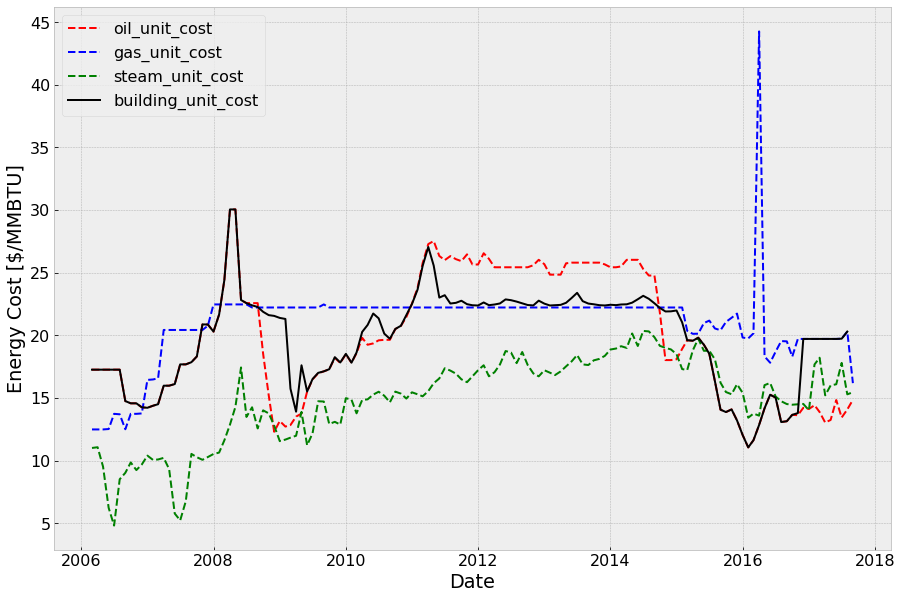

In [735]:
p9g1_filename, p9g1_url = gu.graph_filename_url(site, "energy_cost")
gu.fuel_price_comparison_graph(monthly_heat_energy_and_use, 'date', unit_cost_cols, 'building_unit_cost', p9g1_filename)

## Realized Savings from Fuel Switching: Page 9, Graph 2

In [736]:
monthly_heat_energy_and_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,oil_unit_cost,gas_unit_cost,steam_unit_cost,building_unit_cost,Natural Gas_avg_unit_cost,Oil #1_avg_unit_cost,Steam_avg_unit_cost,calendar_year,calendar_mo,date
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,17.251873,12.480394,11.001751,17.251873,12.480394,14.671069,11.001751,2006,3,2006-03-01
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,12.480396,11.060005,17.251873,12.480396,15.623967,11.060005,2006,4,2006-04-01
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,12.480358,9.512712,17.251873,12.480358,17.954684,9.512712,2006,5,2006-05-01
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,12.512925,6.219821,17.251873,12.512925,17.000551,6.219821,2006,6,2006-06-01
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,13.725490,4.803764,17.251873,13.725490,13.708584,4.803764,2006,7,2006-07-01


In [737]:
# Create an indicator for whether a given heating fuel is available for the facility.  This is done by checking the use for all
# months- if it is zero, then that building doesn't have the option to use that type of fuel.

usage_cols.remove('Electricity')

for col in usage_cols:
    new_col_name = col + "_available"
    monthly_heat_energy_and_use[new_col_name] = np.where(monthly_heat_energy_and_use[col].sum() == 0, 0, 1)

monthly_heat_energy_and_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,...,building_unit_cost,Natural Gas_avg_unit_cost,Oil #1_avg_unit_cost,Steam_avg_unit_cost,calendar_year,calendar_mo,date,Natural Gas_available,Oil #1_available,Steam_available
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,...,17.251873,12.480394,14.671069,11.001751,2006,3,2006-03-01,1,1,0
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,...,17.251873,12.480396,15.623967,11.060005,2006,4,2006-04-01,1,1,0
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,17.251873,12.480358,17.954684,9.512712,2006,5,2006-05-01,1,1,0
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,...,17.251873,12.512925,17.000551,6.219821,2006,6,2006-06-01,1,1,0
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,17.251873,13.725490,13.708584,4.803764,2006,7,2006-07-01,1,1,0


In [738]:
# Calculate what it would have cost if the building used only one fuel type

available_cols = ['Oil #1_available','Natural Gas_available','Steam_available']
available_dict = dict(zip(unit_cost_cols, available_cols))
print (available_dict)
hypothetical_cost_cols = []

for unit_cost, avail_col in available_dict.items():
    new_col_name = unit_cost + "_hypothetical"
    hypothetical_cost_cols.append(new_col_name)
    monthly_heat_energy_and_use[new_col_name] = monthly_heat_energy_and_use[unit_cost] * \
    monthly_heat_energy_and_use.total_heating_energy * monthly_heat_energy_and_use[avail_col]
    
monthly_heat_energy_and_use.head()

{'steam_unit_cost': 'Steam_available', 'oil_unit_cost': 'Oil #1_available', 'gas_unit_cost': 'Natural Gas_available'}


service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,...,Steam_avg_unit_cost,calendar_year,calendar_mo,date,Natural Gas_available,Oil #1_available,Steam_available,steam_unit_cost_hypothetical,oil_unit_cost_hypothetical,gas_unit_cost_hypothetical
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,...,11.001751,2006,3,2006-03-01,1,1,0,0.0,109.953450,79.542803
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,...,11.060005,2006,4,2006-04-01,1,1,0,0.0,286.835088,207.502997
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,9.512712,2006,5,2006-05-01,1,1,0,0.0,296.396257,214.419122
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,...,6.219821,2006,6,2006-06-01,1,1,0,0.0,286.835088,208.043845
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,4.803764,2006,7,2006-07-01,1,1,0,0.0,296.396257,235.811146


In [739]:
# Calculate the monthly savings to the building by not using the most expensive available fuel entirely
monthly_heat_energy_and_use['fuel_switching_savings'] = monthly_heat_energy_and_use[hypothetical_cost_cols].max(axis=1) \
                                                        - monthly_heat_energy_and_use.total_heating_cost

In [740]:
# Sort dataframe to calculate cumulative value
monthly_heat_energy_and_use = monthly_heat_energy_and_use.sort_values(by='date', ascending=True)

# Calculate cumulative value
monthly_heat_energy_and_use['cumulative_fuel_switching_savings'] = np.cumsum(monthly_heat_energy_and_use.fuel_switching_savings)

monthly_heat_energy_and_use

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,...,calendar_mo,date,Natural Gas_available,Oil #1_available,Steam_available,steam_unit_cost_hypothetical,oil_unit_cost_hypothetical,gas_unit_cost_hypothetical,fuel_switching_savings,cumulative_fuel_switching_savings
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,...,3,2006-03-01,1,1,0,0.0,109.953450,79.542803,0.000000e+00,0.000000
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,...,4,2006-04-01,1,1,0,0.0,286.835088,207.502997,0.000000e+00,0.000000
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,5,2006-05-01,1,1,0,0.0,296.396257,214.419122,0.000000e+00,0.000000
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,...,6,2006-06-01,1,1,0,0.0,286.835088,208.043845,0.000000e+00,0.000000
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,7,2006-07-01,1,1,0,0.0,296.396257,235.811146,0.000000e+00,0.000000
5,2007,2,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,8,2006-08-01,1,1,0,0.0,296.396257,235.190501,0.000000e+00,0.000000
6,2007,3,NaN,797.834906,0.0,797.834906,NaN,54.112846,0.0,54.112846,...,9,2006-09-01,1,1,0,0.0,797.834906,676.104089,0.000000e+00,0.000000
7,2007,4,NaN,970.481124,0.0,970.481124,NaN,66.630843,0.0,66.630843,...,10,2006-10-01,1,1,0,0.0,970.481124,914.540978,0.000000e+00,0.000000
8,2007,5,NaN,939.175281,0.0,939.175281,NaN,64.481461,0.0,64.481461,...,11,2006-11-01,1,1,0,0.0,939.175281,885.039656,0.000000e+00,0.000000
9,2007,6,NaN,1043.385846,0.0,1043.385846,NaN,73.236728,0.0,73.236728,...,12,2006-12-01,1,1,0,0.0,1043.385846,1007.559264,0.000000e+00,0.000000


C:\Anaconda2\envs\py35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


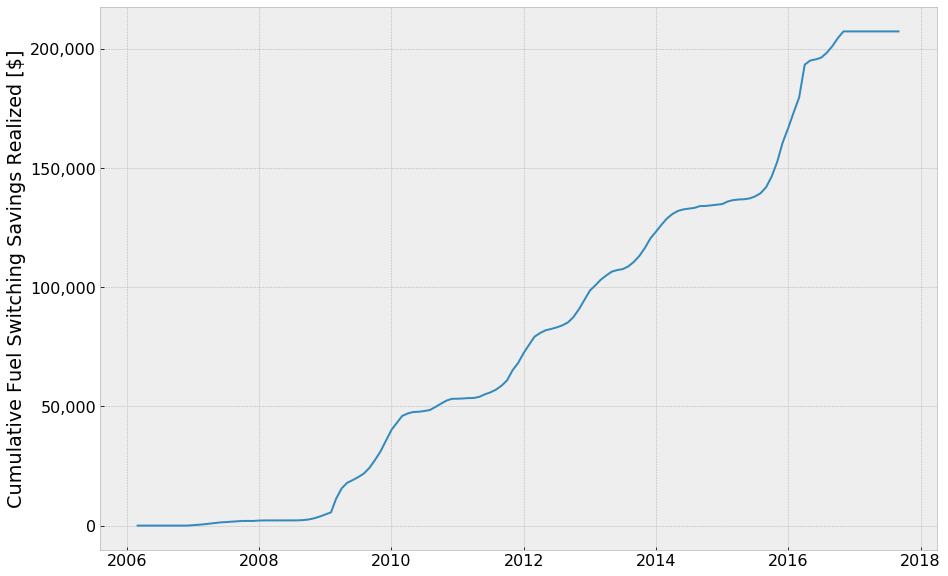

In [741]:
p9g2_filename, p9g2_url = gu.graph_filename_url(site, "cumulative_fuel_switching_savings")
gu.create_monthly_line_graph(monthly_heat_energy_and_use, 'date', 'cumulative_fuel_switching_savings',
                            'Cumulative Fuel Switching Savings Realized [$]', p9g2_filename)

# Water Analysis Table - Page 10

In [742]:
water_use = df.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo','cost', 'usage', 'units']]
water_use

,service_type,fiscal_year,fiscal_mo,cost,usage,units
48636,Electricity,2006,12,1971.105000,24960.000000,kWh
48637,Electricity,2006,12,931.745000,117.000000,kW
48638,Electricity,2006,12,621.220000,NaN,-
48639,Electricity,2007,1,3736.435000,47100.000000,kWh
48640,Electricity,2007,1,1863.490000,234.000000,kW
48641,Electricity,2007,1,1175.080000,NaN,-
48642,Electricity,2007,2,3476.768548,43409.032258,kWh
48643,Electricity,2007,2,1923.602581,241.548387,kW
48644,Electricity,2007,2,1322.270323,NaN,-
48645,Electricity,2007,3,4297.047166,54695.253456,kWh


In [743]:
# Create month count field for all months that have water and sewer bills
water_use_only = water_use.query("service_type == 'Water'")
water_months_present = bu.months_present(water_use_only)
water_mo_count = bu.month_count(water_months_present)
water_mo_count

year
2007     9
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018     3
Name: month, dtype: int64

In [744]:
# Create annual water gallon usage dataframe
water_gal_df = pd.pivot_table(water_use, 
                              values='usage',
                              index=['fiscal_year',], 
                              columns=['service_type'],
                              aggfunc=np.sum
)

water_gal_df.head()

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water
fiscal_year,,,,,
2006,2.507700e+04,NaN,420.789474,NaN,NaN
2007,1.194041e+06,NaN,5372.449163,1.712421e+06,1.712421e+06
2008,1.314766e+06,NaN,5455.011364,1.765586e+06,1.765586e+06
2009,1.375791e+06,50973.500000,15648.940476,1.682894e+06,1.682894e+06
2010,1.464370e+06,5551.733333,50955.673160,2.272170e+06,2.272170e+06


In [745]:
# Use only required columns 
water_gal_df = water_gal_df[['Water']]
# Calculate percent change column
water_gal_df['water_use_pct_change'] = water_gal_df.Water.pct_change()

In [746]:
# Create annual water and sewer cost dataframe
water_cost_df = pd.pivot_table(water_use, 
                              values='cost',
                              index=['fiscal_year',], 
                              columns=['service_type'],
                              aggfunc=np.sum
)

water_cost_df.head()

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water
fiscal_year,,,,,
2006,3524.070000,NaN,980.019883,NaN,NaN
2007,150960.622031,NaN,10852.587503,16947.621429,13737.110714
2008,213135.022187,NaN,15560.320114,18513.418866,17242.660168
2009,200554.873496,116398.452000,30202.520595,17648.170849,16545.263403
2010,232795.478576,13314.745167,124264.351905,24156.588500,21808.169107


In [747]:
# Calculate totals, percent change
water_cost_df = water_cost_df[['Sewer', 'Water']]
water_cost_df = water_cost_df.rename(columns={'Sewer': 'Sewer Cost',
                                             'Water': 'Water Cost'})
water_cost_df['total_water_sewer_cost'] = water_cost_df['Sewer Cost'] + water_cost_df['Water Cost']
water_cost_df['water_cost_pct_change'] = water_cost_df['Water Cost'].pct_change()
water_cost_df['sewer_cost_pct_change'] = water_cost_df['Sewer Cost'].pct_change()
water_cost_df['total_water_sewer_cost_pct_change'] = water_cost_df.total_water_sewer_cost.pct_change()

In [748]:
# Merge use and cost dataframes
water_use_and_cost = pd.merge(water_cost_df, water_gal_df, left_index=True, right_index=True, how='outer')
water_use_and_cost.head()

service_type,Sewer Cost,Water Cost,total_water_sewer_cost,water_cost_pct_change,sewer_cost_pct_change,total_water_sewer_cost_pct_change,Water,water_use_pct_change
fiscal_year,,,,,,,,
2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,16947.621429,13737.110714,30684.732143,NaN,NaN,NaN,1.712421e+06,NaN
2008,18513.418866,17242.660168,35756.079034,0.255188,0.092390,0.165273,1.765586e+06,0.031047
2009,17648.170849,16545.263403,34193.434252,-0.040446,-0.046736,-0.043703,1.682894e+06,-0.046835
2010,24156.588500,21808.169107,45964.757607,0.318091,0.368787,0.344257,2.272170e+06,0.350157


In [749]:
water_use_and_cost['water_unit_cost'] = water_use_and_cost.total_water_sewer_cost / water_use_and_cost.Water
water_use_and_cost['water_unit_cost_pct_change'] = water_use_and_cost.water_unit_cost.pct_change()

# Use only complete years 
water_use_and_cost['month_count'] = water_mo_count
water_use_and_cost = water_use_and_cost.query("month_count == 12")
water_use_and_cost = water_use_and_cost.sort_index(ascending=False)
water_use_and_cost

service_type,Sewer Cost,Water Cost,total_water_sewer_cost,water_cost_pct_change,sewer_cost_pct_change,total_water_sewer_cost_pct_change,Water,water_use_pct_change,water_unit_cost,water_unit_cost_pct_change,month_count
fiscal_year,,,,,,,,,,,
2017,20166.372612,19001.609888,39167.982500,0.059823,0.028483,0.043452,1.606898e+06,0.024049,0.024375,0.018948,12.0
2016,19607.886225,17929.045186,37536.931411,-0.042154,0.014424,-0.013411,1.569161e+06,-0.100524,0.023922,0.096849,12.0
2015,19329.089516,18718.094839,38047.184355,-0.034700,-0.034224,-0.034458,1.744529e+06,-0.064601,0.021809,0.032225,12.0
2014,20014.054124,19390.952860,39405.006984,-0.018030,0.007973,-0.004993,1.865012e+06,0.007831,0.021129,-0.012724,12.0
2013,19855.745738,19746.999190,39602.744929,-0.056122,-0.138067,-0.099066,1.850520e+06,-0.009826,0.021401,-0.090126,12.0
2012,23036.310714,20921.145357,43957.456071,0.018582,0.021279,0.019994,1.868884e+06,-0.113235,0.023521,0.150241,12.0
2011,22556.336071,20539.473393,43095.809464,-0.058175,-0.066245,-0.062416,2.107529e+06,-0.072460,0.020449,0.010828,12.0
2010,24156.588500,21808.169107,45964.757607,0.318091,0.368787,0.344257,2.272170e+06,0.350157,0.020229,-0.004370,12.0
2009,17648.170849,16545.263403,34193.434252,-0.040446,-0.046736,-0.043703,1.682894e+06,-0.046835,0.020318,0.003287,12.0


## Create Water Cost Stacked Bar Graph - Page 10 Graph 1

C:\Anaconda2\envs\py35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


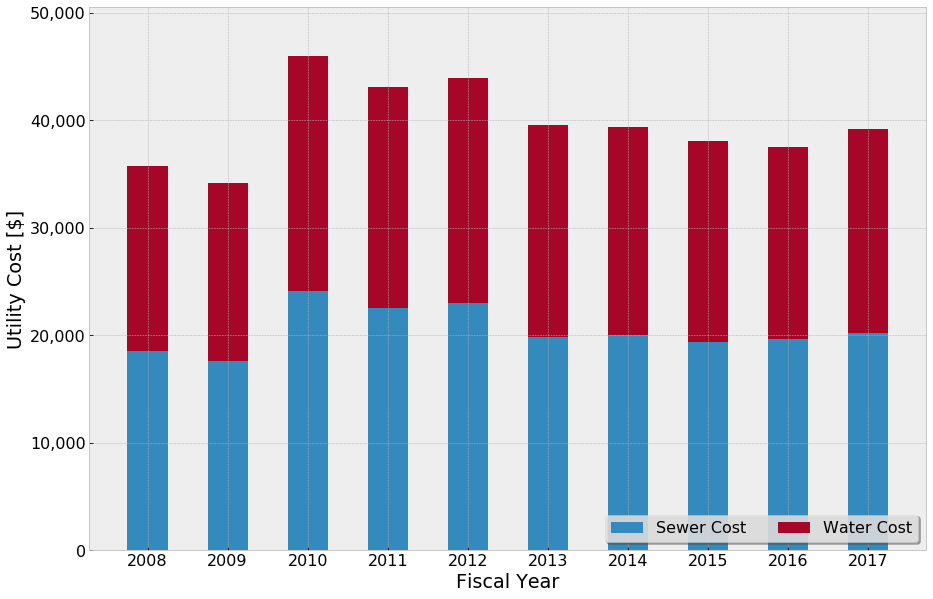

In [750]:

p10g1_filename, p10g1_url = gu.graph_filename_url(site, "utility_cost")
gu.create_stacked_bar(water_use_and_cost.reset_index(), 'fiscal_year', ['Sewer Cost', 'Water Cost'], 
                      'Utility Cost [$]', p10g1_filename)

## Create Monthly Profile of Water Usage - Page 10 Graph 2

In [751]:
# Create monthly water gallon dataframe
water_gal_df_monthly = pd.pivot_table(water_use, 
                              values='usage',
                              index=['fiscal_year', 'fiscal_mo'], 
                              columns=['service_type'],
                              aggfunc=np.sum
)

water_gal_df_monthly.head()

service_type           Electricity  Natural Gas      Oil #1  Sewer  Water
fiscal_year fiscal_mo                                                    
2006        9                  NaN          NaN   47.210526    NaN    NaN
            10                 NaN          NaN  123.157895    NaN    NaN
            11                 NaN          NaN  127.263158    NaN    NaN
            12             25077.0          NaN  123.157895    NaN    NaN
2007        1              47334.0          NaN  127.263158    NaN    NaN

C:\Anaconda2\envs\py35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


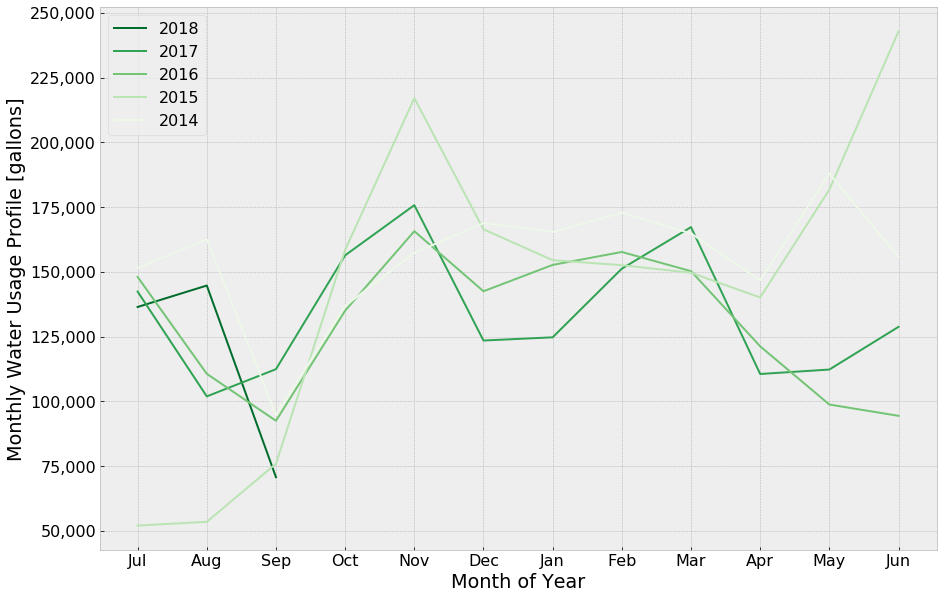

In [752]:
p10g2_filename, p10g2_url = gu.graph_filename_url(site, "monthly_water_usage_profile")
gu.create_monthly_profile(water_gal_df_monthly, 'Water', 'Monthly Water Usage Profile [gallons]', 'green', p10g2_filename)